In [1]:
import os
import re
import json
import nltk
import string
import enchant
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

#### Data Inspection

In [2]:
covid_data = pd.read_csv('covid19_tweets.csv', encoding='utf-8')
covid_label = pd.read_csv('covid19_tweets_processed.csv')
covid_data = pd.concat([covid_data, covid_label], axis=1)
covid_data.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'label'],
      dtype='object')

In [3]:
covid_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,label
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,0
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,1
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,0
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,0


#### Data Cleaning

In [4]:
# clean @at, namely clean username
def clean_at(data):
    return re.sub('@[^\s]+', ' ', data)

# clean URLs
def clean_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

# clean &amp
def clean_amp(data):
    return  ' '.join([word for word in data.split() if word != 'amp'])

# clean numbers
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)

def clean_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
    

# clean non-english words
def clean_non_english_word(data):
    d = enchant.Dict('en_US') # english dictionary
    return ' '.join([word for word in data.split() if d.check(word)])

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
def clean_stopwords(data):
    return ' '.join([word for word in data.split() if word not in stopwords])

def clean_punctuations(data):
    punctuations_list = string.punctuation
    translator = str.maketrans('', '', punctuations_list)
    return data.translate(translator)

# stemming
def stemming(data):
    st = PorterStemmer()
    return ' '.join([st.stem(word) for word in data.split()])

# Lemmatization
def lemmatization(data):
    wnl = WordNetLemmatizer()
    return ' '.join([wnl.lemmatize(word) for word in data.split()])

In [5]:
covid_data['text'] = covid_data['text'].str.lower()
covid_data['text'] = covid_data['text'].apply(lambda x:clean_at(x))
covid_data['text'] = covid_data['text'].apply(lambda x:clean_URLs(x))
covid_data['text'] = covid_data['text'].apply(lambda x:clean_emojis(x))
covid_data['text'] = covid_data['text'].str.replace("[^a-zA-Z#]", " ")
covid_data['text'] = covid_data['text'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '')
covid_data['text'] = covid_data['text'].str.replace('@[A-Za-z0-9]+', '') 
covid_data['text'] = covid_data['text'].str.replace('\n', ' ') 
covid_data['text'] = covid_data['text'].apply(lambda x: clean_non_english_word(x))
covid_data['text'] = covid_data['text'].apply(lambda x: clean_stopwords(x))
covid_data['text'] = covid_data['text'].apply(lambda x: clean_punctuations(x))
covid_data['text'] = covid_data['text'].apply(lambda x: lemmatization(x))
covid_data['text'] = covid_data['text'].apply(lambda x:clean_amp(x))
covid_data['text'].head()

/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_4870/971940101.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['text'] = covid_data['text'].str.replace("[^a-zA-Z#]", " ")
/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_4870/971940101.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['text'] = covid_data['text'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '')
/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_4870/971940101.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['text'] = covid_data['text'].str.replace('@[A-Za-z0-9]+', '')


0    smelled scent hand sanitizers today someone pa...
1                    hey made sense player pay respect
2                trump never claimed hoax claim effort
3    one gift give appreciation simple thing always...
4                                medium bulletin novel
Name: text, dtype: object

In [137]:
covid_data['user_description'] = covid_data['user_description'].replace(np.nan, '', regex=True)
covid_data['user_description'] = covid_data['user_description'].str.lower()
covid_data['user_description'] = covid_data['user_description'].apply(lambda x:clean_at(x))
covid_data['user_description'] = covid_data['user_description'].apply(lambda x:clean_URLs(x))
covid_data['user_description'] = covid_data['user_description'].apply(lambda x:clean_amp(x))
covid_data['user_description'] = covid_data['user_description'].apply(lambda x:clean_emojis(x))
covid_data['user_description'] = covid_data['user_description'].str.replace("[^a-zA-Z#]", " ")
covid_data['user_description'] = covid_data['user_description'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '')
covid_data['user_description'] = covid_data['user_description'].str.replace('@[A-Za-z0-9]+', '') 
covid_data['user_description'] = covid_data['user_description'].str.replace('\n', ' ') 
covid_data['user_description'] = covid_data['user_description'].apply(lambda x: clean_non_english_word(x))
covid_data['user_description'] = covid_data['user_description'].apply(lambda x: clean_stopwords(x))
covid_data['user_description'] = covid_data['user_description'].apply(lambda x: clean_punctuations(x))
covid_data['user_description'] = covid_data['user_description'].apply(lambda x: lemmatization(x))
covid_data['user_description'].head()

/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_5249/2674251387.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['user_description'] = covid_data['user_description'].str.replace("[^a-zA-Z#]", " ")
/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_5249/2674251387.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['user_description'] = covid_data['user_description'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '')
/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_5249/2674251387.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['user_description'] = covid_data['user_description'].str.replace('@[A-Za-z0-9]+', '')


0                                             princess
1    husband father columnist commentator author to...
2                                          sport lover
3                                                     
4    official twitter handle department information...
Name: user_description, dtype: object

In [ ]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

from tqdm import tqdm
sentiments = []
for i in tqdm(range(len(covid_data))):
    tweet = covid_data['text'][i]
    sentiment = classifier(tweet)[0]['label']
    sentiments.append(sentiment)

sentiments = pd.DataFrame(sentiments)
sentiments.columns = ['sentiment']

df = pd.DataFrame(sentiments)
df.to_csv('sentiment.csv', index=False)

In [5]:
sentiments = pd.read_csv('sentiment.csv')
sentiments

,sentiment
0,NEGATIVE
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
...,...
179103,POSITIVE
179104,NEGATIVE
179105,POSITIVE
179106,POSITIVE


In [6]:
covid_data = pd.concat([covid_data, sentiments], axis=1)

In [7]:
rumours = covid_data[covid_data['label']==1]
rumours = rumours.reset_index(drop=True)
nonrumours = covid_data[covid_data['label']==0]
nonrumours = nonrumours.reset_index(drop=True)

#### Frequency Visualization

#### Visualization Functions

In [8]:
def visualize_freq(set, factor, factor_type, top_cnt, label_type, output_fname):
    all_vals = []
    for i in range(len(set)):
        if factor == 'text' or factor == 'user_description':
            values = set[factor][i].split()
            # word
            if values != []:
                for val in values:
                    all_vals.append(val)
        
        if factor == 'hashtags':
            values = set[factor][i]
            if str(values) != 'nan':
                values = eval(values)
                for val in values:
                    all_vals.append(val)
        
        if factor == 'user_location':
            location = set[factor][i]
            if str(location) != 'nan':
                all_vals.append(location)

        if factor == 'user_verified' or factor == 'user_name' or factor == 'sentiment' or factor == 'source':
            verify = set[factor][i]
            all_vals.append(verify)

        if factor == 'user_created':
            created_date = set[factor][i]
            created_date = datetime.strptime(created_date, "%Y-%m-%d %H:%M:%S")
            created_date = created_date.strftime('%Y')
            if created_date not in all_vals:
                all_vals.append(created_date)
            

    counter = Counter(all_vals)
    vals = list(counter.keys())
    freqs = list(counter.values())

    vals_freqs = pd.DataFrame([freqs]).T
    vals_freqs.columns = ['frequency']
    vals_freqs.index = vals
    vals_freqs = vals_freqs.sort_values('frequency', ascending=False)
    
    # top xxx frequent vals
    frequent_vals = vals_freqs['frequency'][:top_cnt].index

    # plot
    title = "{} Frequency in {} Tweets".format(factor_type, label_type)
    plt.figure(figsize=(12, 18))
    plt.bar(np.arange(top_cnt), vals_freqs['frequency'][:top_cnt], width=0.8, color = sns.color_palette("bwr"), alpha=0.5, 
                edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(top_cnt), frequent_vals, fontname="Times New Roman", rotation=90, size=24);
    plt.xlabel("{} most frequent {}".format(str(top_cnt), factor_type), size=28, labelpad=16, fontname="Times New Roman");
    plt.ylabel("Frequency", size=28, labelpad=16, fontname="Times New Roman");
    plt.title(title, size=34, fontname="Times New Roman");
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
    plt.show()
    return frequent_vals

In [9]:
def visualize_freq_percentage(set, factor, factor_type, top_cnt, label_type, output_fname):
    all_vals = []
    for i in range(len(set)):
        if factor == 'text' or factor == 'user_description':
            values = set[factor][i].split()
            # word
            if values != []:
                for val in values:
                    all_vals.append(val)
        
        if factor == 'hashtags':
            values = set[factor][i]
            if str(values) != 'nan':
                values = eval(values)
                for val in values:
                    all_vals.append(val)
        
        if factor == 'user_location':
            location = set[factor][i]
            if str(location) != 'nan':
                all_vals.append(location)

        if factor == 'user_verified' or factor == 'user_name' or factor == 'sentiment' or factor == 'source':
            verify = set[factor][i]
            all_vals.append(verify)

        if factor == 'user_created':
            created_date = set[factor][i]
            created_date = datetime.strptime(created_date, "%Y-%m-%d %H:%M:%S")
            created_date = created_date.strftime('%Y')
            if created_date not in all_vals:
                all_vals.append(created_date)
            

    counter = Counter(all_vals)
    vals = list(counter.keys())
    freqs = list(counter.values())
    freqs = [round(freq/len(all_vals),4)*100 for freq in freqs]

    vals_freqs = pd.DataFrame([freqs]).T
    vals_freqs.columns = ['frequency percentage']
    vals_freqs.index = vals
    vals_freqs = vals_freqs.sort_values('frequency percentage', ascending=False)
    # top xxx frequent vals
    frequent_vals = vals_freqs['frequency percentage'][:top_cnt].index
    print(frequent_vals)

    # plot
    title = "{} Frequency Percentage in {} Tweets".format(factor_type, label_type)
    plt.figure(figsize=(10,12))
    plt.bar(np.arange(top_cnt), vals_freqs['frequency percentage'][:top_cnt], width=0.8, color = sns.color_palette("bwr"), alpha=0.5, 
                edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(top_cnt), frequent_vals, rotation=90, size=14, fontname="Times New Roman");
    plt.xlabel("{} most frequent {}".format(str(top_cnt), factor_type), size=14, labelpad=6, fontname="Times New Roman");
    plt.ylabel("Frequency %", size=14, labelpad=6, fontname="Times New Roman");
    plt.title(title, size=18, fontname="Times New Roman")
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
    plt.show()
    return vals_freqs[:top_cnt]

In [10]:
def visualize_wordcloud(wc_str, label_type, output_fname):
    mask = np.array(Image.open('images/twitter-icon.png'))
    wc = WordCloud(background_color='white', colormap='Set1', mask=mask).generate(wc_str)
    title = '{} Tweets WordCloud'.format(label_type)
    plt.figure(figsize=(6,6), facecolor="w")
    plt.title(title, size=18, fontname="Times New Roman")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('images/'+output_fname, dpi=300)
    plt.show()

rumours_str = pd.Series(rumours['text']).str.cat(sep=' ')
nonrumours_str = pd.Series(nonrumours['text']).str.cat(sep=' ')

In [13]:
def visualize_distribution(set, factor, factor_type, top_cnt, set_type, output_fname):
    all_vals = []
    for i in range(len(set)):
        if factor == 'text':
            values = set[factor][i].split()
            # word
            if values != []:
                for val in values:
                    all_vals.append(val)
        
        if factor == 'hashtags':
            values = set[factor][i]
            if str(values) != 'nan':
                values = eval(values)
                for val in values:
                    all_vals.append(val)
        
        if factor == 'user_location':
            location = set[factor][i]
            if str(location) != 'nan':
                all_vals.append(location)
        
        if factor == 'user_verified' or factor == 'user_name' or factor == 'sentiment' or factor == 'source':
            verify = set[factor][i]
            all_vals.append(verify)

        if factor == 'user_created':
            created_date = set[factor][i]
            created_date = datetime.strptime(created_date, "%Y-%m-%d %H:%M:%S")
            created_date = created_date.strftime('%Y')
            all_vals.append(created_date)
    
    counter = Counter(all_vals)
    vals = list(counter.keys())
    freqs = list(counter.values())

    vals_freqs = pd.DataFrame([freqs]).T
    vals_freqs.columns = ['frequency']
    vals_freqs.index = vals
    vals_freqs = vals_freqs.sort_values('frequency', ascending=False)
    top_freqs = vals_freqs[:top_cnt]
    # top xxx frequent vals
    frequent_vals = top_freqs['frequency'].index

    # plot
    cmap = plt.get_cmap('RdPu')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    plt.figure(figsize=(6, 6))
    plt.pie(top_freqs['frequency'], labels = list(top_freqs.index), autopct='%1.1f%%', colors=colors)
    title = "{} Distribution in {} Tweets".format(factor_type.title(), set_type)
    plt.title(title, size=18, fontname="Times New Roman")
    plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
    plt.show()
    return top_freqs

#### Word Frequency Visualization

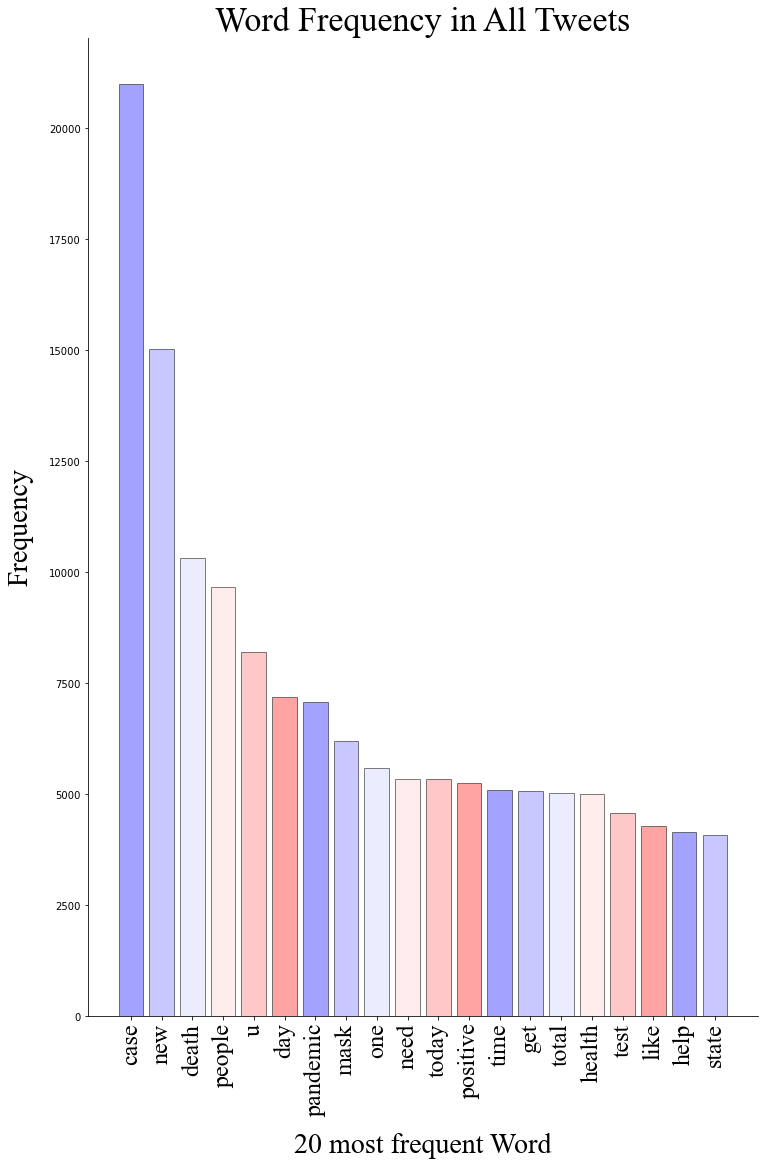

Index(['case', 'new', 'death', 'people', 'u', 'day', 'pandemic', 'mask', 'one',
       'need', 'today', 'positive', 'time', 'get', 'total', 'health', 'test',
       'like', 'help', 'state'],
      dtype='object')

In [34]:
visualize_freq(covid_data, 'text', 'Word', 20, 'All', 'word-freq-all.png') 

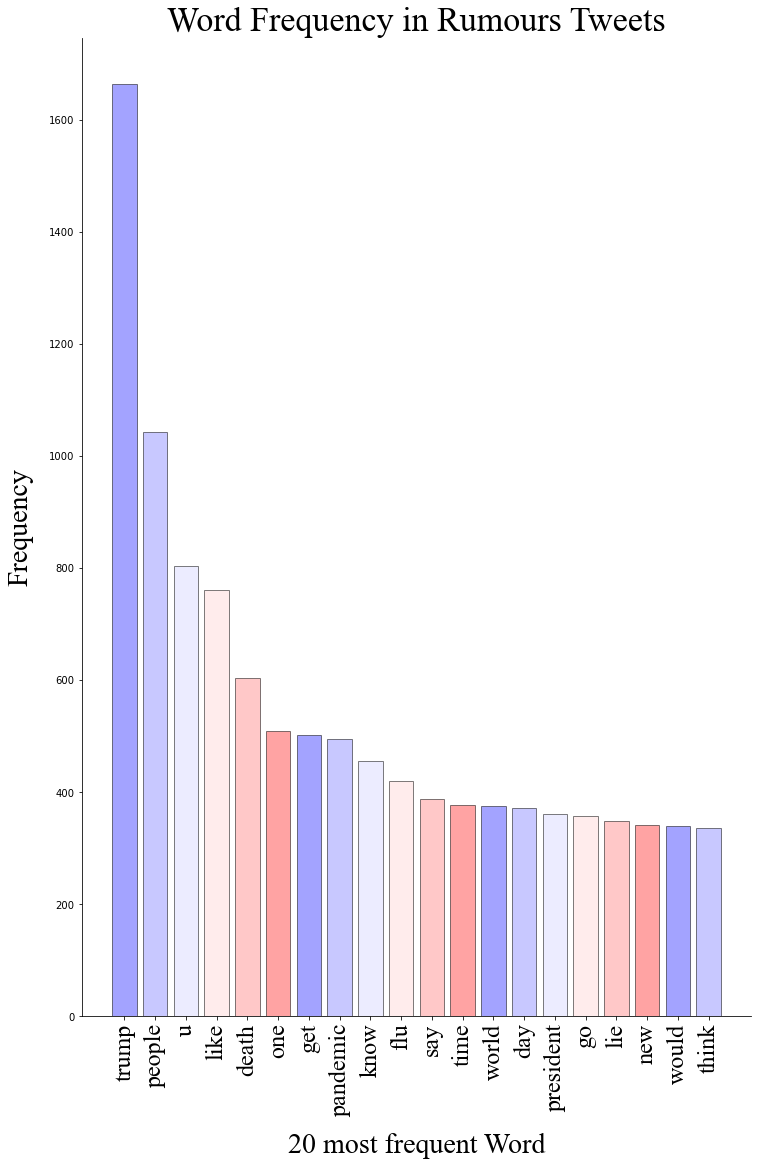

Index(['trump', 'people', 'u', 'like', 'death', 'one', 'get', 'pandemic',
       'know', 'flu', 'say', 'time', 'world', 'day', 'president', 'go', 'lie',
       'new', 'would', 'think'],
      dtype='object')

In [35]:
visualize_freq(rumours, 'text', 'Word', 20, 'Rumours', 'word-freq-rumours.png')

Index(['trump', 'amp', 'people', 'u', 'like', 'death', 'one', 'get',
       'pandemic', 'know', 'flu', 'say', 'time', 'world', 'day', 'go',
       'president', 'lie', 'would', 'think'],
      dtype='object')


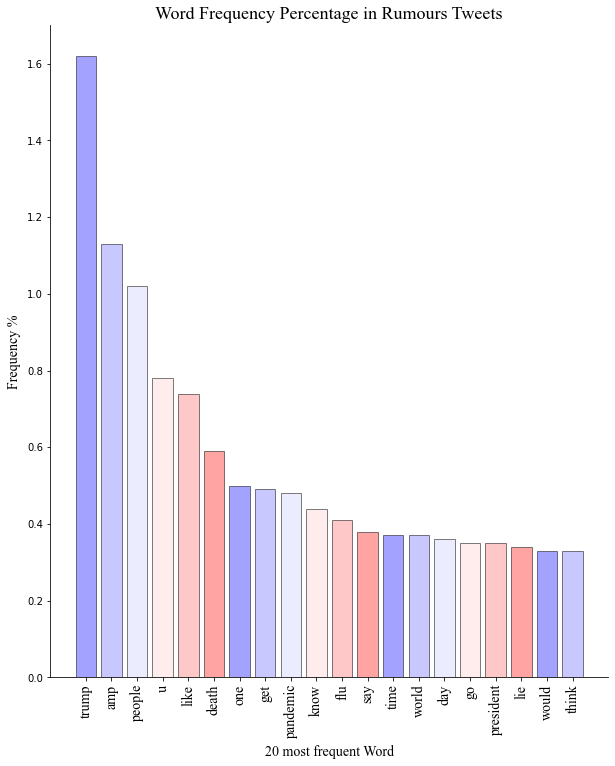

,frequency percentage
trump,1.62
amp,1.13
people,1.02
u,0.78
like,0.74
death,0.59
one,0.50
get,0.49
pandemic,0.48
know,0.44


In [18]:
tmp_rumour = visualize_freq_percentage(rumours, 'text', 'Word', 20, 'Rumours', 'word-freq-per-rumours.png')
tmp_rumour

Index(['case', 'new', 'death', 'people', 'u', 'day', 'pandemic', 'mask',
       'positive', 'one', 'today', 'need', 'total', 'health', 'time', 'test',
       'get', 'help', 'update', 'state'],
      dtype='object')


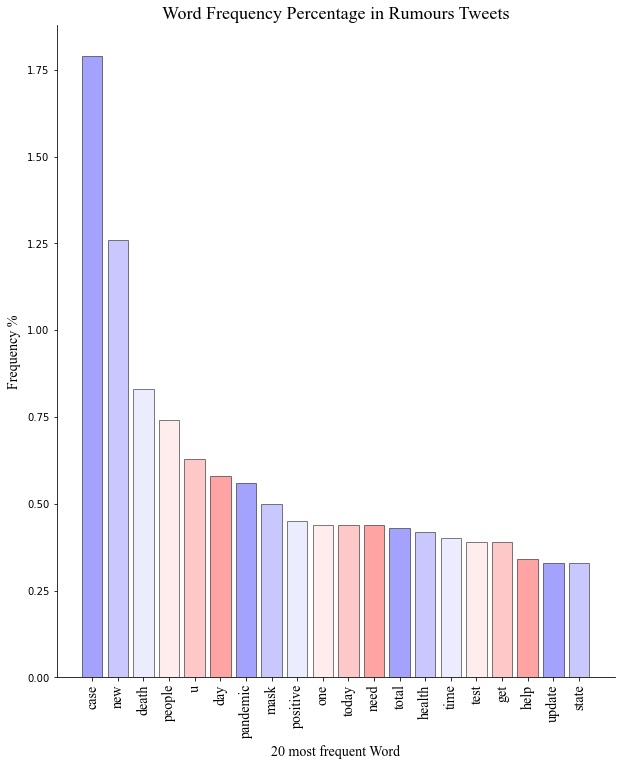

,frequency percentage
case,1.79
new,1.26
death,0.83
people,0.74
u,0.63
day,0.58
pandemic,0.56
mask,0.50
positive,0.45
one,0.44


In [36]:
tmp_nonrumour = visualize_freq_percentage(nonrumours, 'text', 'Word', 20, 'Rumours', 'word-freq-per-rumours.png')
tmp_nonrumour

In [37]:
tmp_nonrumour.index

Index(['case', 'new', 'death', 'people', 'u', 'day', 'pandemic', 'mask',
       'positive', 'one', 'today', 'need', 'total', 'health', 'time', 'test',
       'get', 'help', 'update', 'state'],
      dtype='object')

In [38]:
nonrumour_topic = ['case', 'new', 'death', 'people', 'pandemic', 'positive', 'mask', 'total', 'heath']
nonrumour_topics_freqs = [1.79, 1.26, 0.83, 0.74, 0.56, 0.5, 0.45, 0.43, 0.42]
nonrumour_topics = pd.DataFrame(nonrumour_topics_freqs)
nonrumour_topics.columns = ['frequency']
nonrumour_topics.index = nonrumour_topic
nonrumour_topics

,frequency
case,1.79
new,1.26
death,0.83
people,0.74
pandemic,0.56
positive,0.50
mask,0.45
total,0.43
heath,0.42


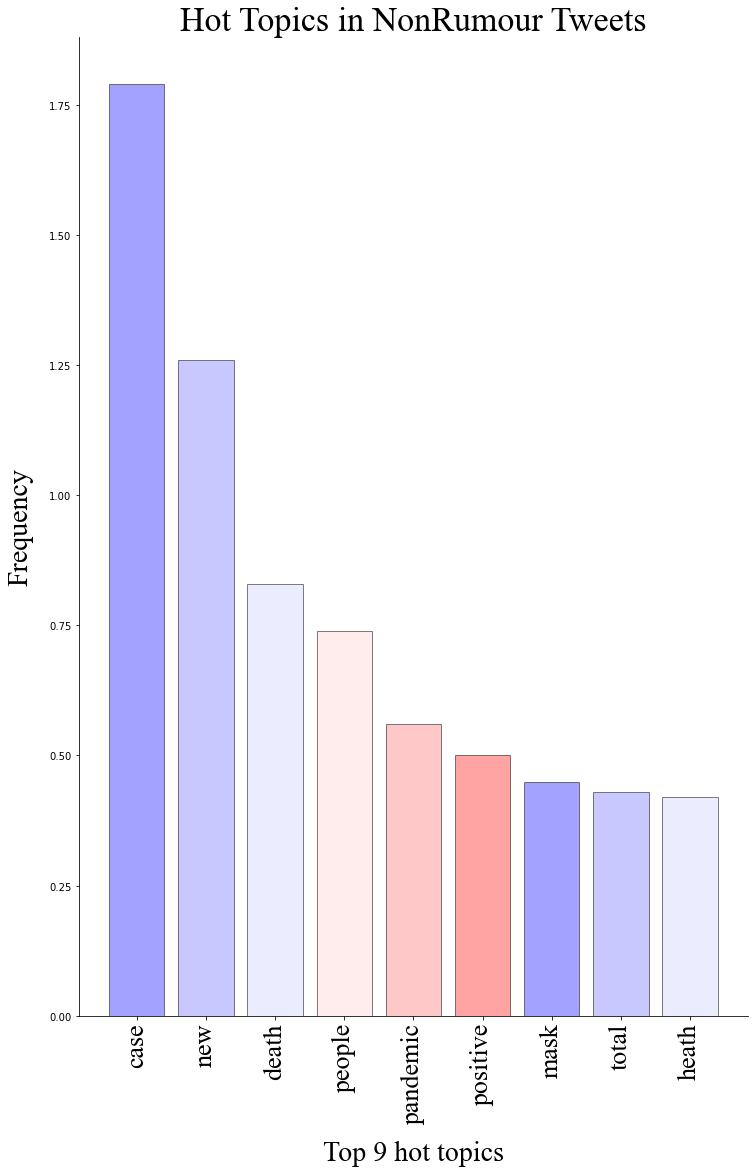

In [39]:
# plot
top_cnt = 9
vals_freqs = nonrumour_topics
frequent_vals = list(nonrumour_topics.index)
factor_type = 'Hot Topics'
label_type = 'NonRumour'
output_fname = 'non-rumour-topics.png'

title = "{} in {} Tweets".format(factor_type, label_type)
plt.figure(figsize=(12,18))

plt.bar(np.arange(top_cnt), vals_freqs['frequency'][:top_cnt], width=0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
plt.xticks(np.arange(top_cnt), frequent_vals, fontname="Times New Roman", rotation=90, size=26);
plt.xlabel("Top {} hot topics".format(str(top_cnt)), size=28, labelpad=16, fontname="Times New Roman");
plt.ylabel("Frequency", size=28, labelpad=16, fontname="Times New Roman");
plt.title(title, size=34, fontname="Times New Roman");

plt.grid(False);
plt.gca().spines["top"].set_visible(False);
plt.gca().spines["right"].set_visible(False);
plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
plt.show()

In [40]:
rumour_topic = ['trump', 'people', 'death', 'pandemic', 'flu', 'world', 'president', 'lie', 'new']
rumour_topics_freqs = [1.64, 1.03, 0.6, 0.49, 0.41, 0.37, 0.36, 0.34, 0.34]
rumour_topics = pd.DataFrame(rumour_topics_freqs)
rumour_topics.columns = ['frequency']
rumour_topics.index = rumour_topic
rumour_topics

,frequency
trump,1.64
people,1.03
death,0.60
pandemic,0.49
flu,0.41
world,0.37
president,0.36
lie,0.34
new,0.34


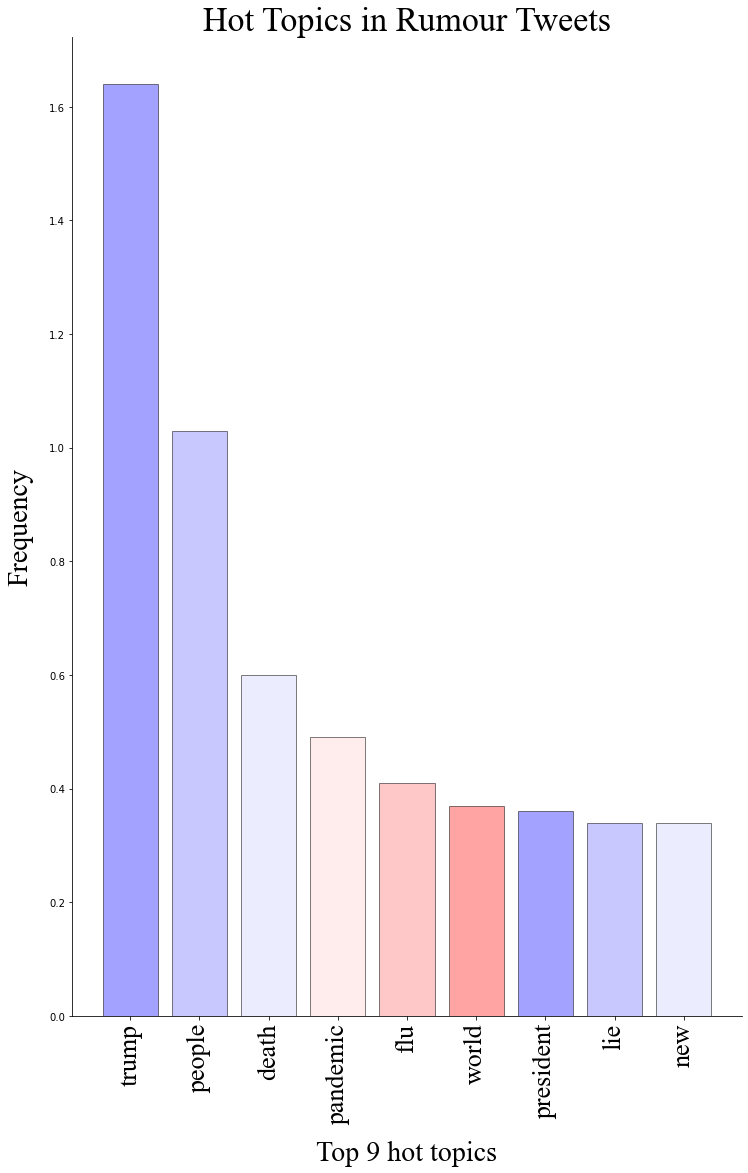

In [41]:
# plot
top_cnt = 9
vals_freqs = rumour_topics
frequent_vals = list(rumour_topics.index)
factor_type = 'Hot Topics'
label_type = 'Rumour'
output_fname = 'rumour-topics.png'

title = "{} in {} Tweets".format(factor_type, label_type)
plt.figure(figsize=(12,18))

plt.bar(np.arange(top_cnt), vals_freqs['frequency'][:top_cnt], width=0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
plt.xticks(np.arange(top_cnt), frequent_vals, fontname="Times New Roman", rotation=90, size=26);
plt.xlabel("Top {} hot topics".format(str(top_cnt)), size=28, labelpad=16, fontname="Times New Roman");
plt.ylabel("Frequency", size=28, labelpad=16, fontname="Times New Roman");
plt.title(title, size=34, fontname="Times New Roman");

plt.grid(False);
plt.gca().spines["top"].set_visible(False);
plt.gca().spines["right"].set_visible(False);
plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
plt.show()

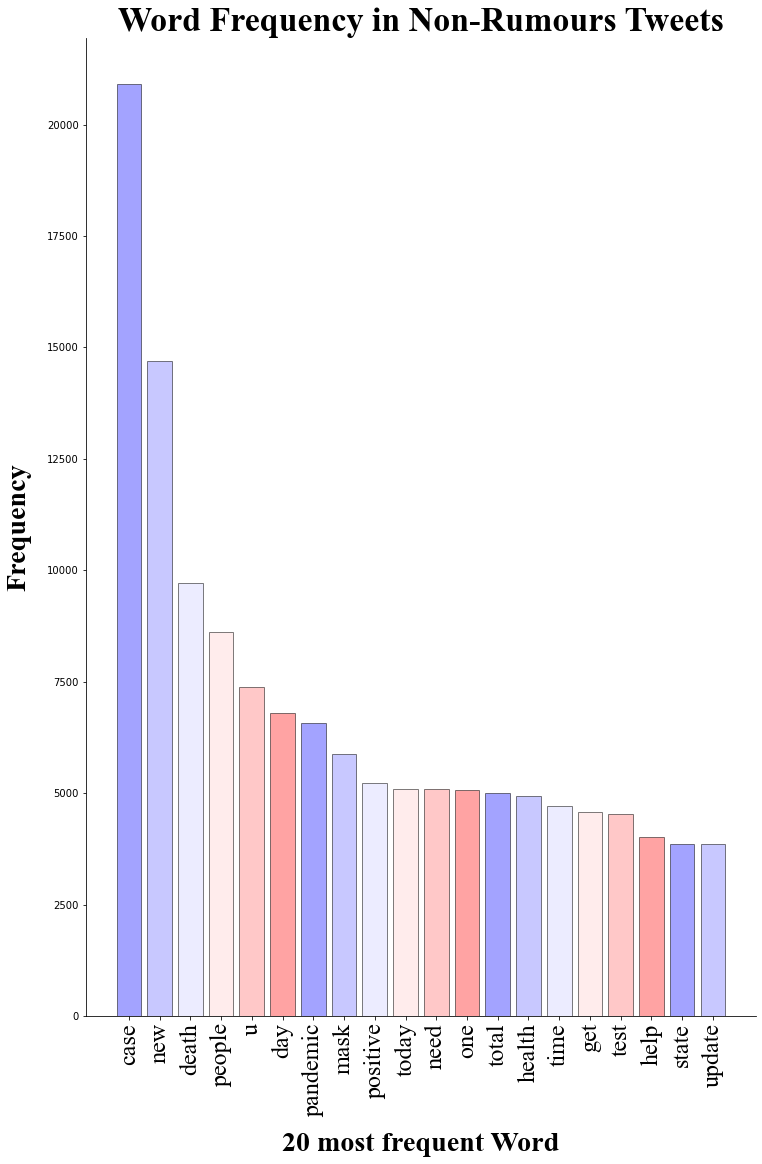

Index(['case', 'new', 'death', 'people', 'u', 'day', 'pandemic', 'mask',
       'positive', 'today', 'need', 'one', 'total', 'health', 'time', 'get',
       'test', 'help', 'state', 'update'],
      dtype='object')

In [175]:
visualize_freq(nonrumours, 'text', 'Word', 20, 'Non-Rumours', 'word-freq-nonrumours.png')

#### Hashtag Frequency Visualization

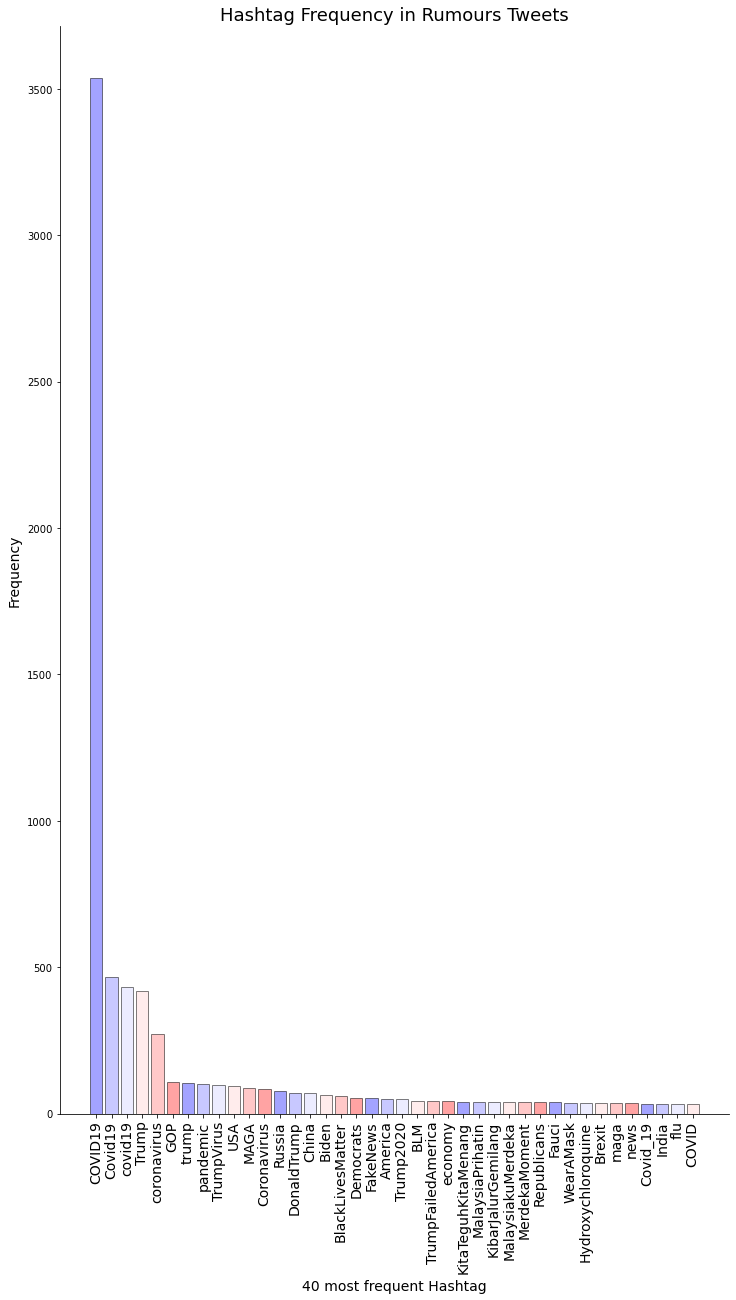

Index(['COVID19', 'Covid19', 'covid19', 'Trump', 'coronavirus', 'GOP', 'trump',
       'pandemic', 'TrumpVirus', 'USA', 'MAGA', 'Coronavirus', 'Russia',
       'DonaldTrump', 'China', 'Biden', 'BlackLivesMatter', 'Democrats',
       'FakeNews', 'America', 'Trump2020', 'BLM', 'TrumpFailedAmerica',
       'economy', 'KitaTeguhKitaMenang', 'MalaysiaPrihatin',
       'KibarJalurGemilang', 'MalaysiakuMerdeka', 'MerdekaMoment',
       'Republicans', 'Fauci', 'WearAMask', 'Hydroxychloroquine', 'Brexit',
       'maga', 'news', 'Covid_19', 'India', 'flu', 'COVID'],
      dtype='object')

In [47]:
visualize_freq(rumours, 'hashtags', 'Hashtag', 40, 'Rumours', 'hashtag-freq-rumours.png')

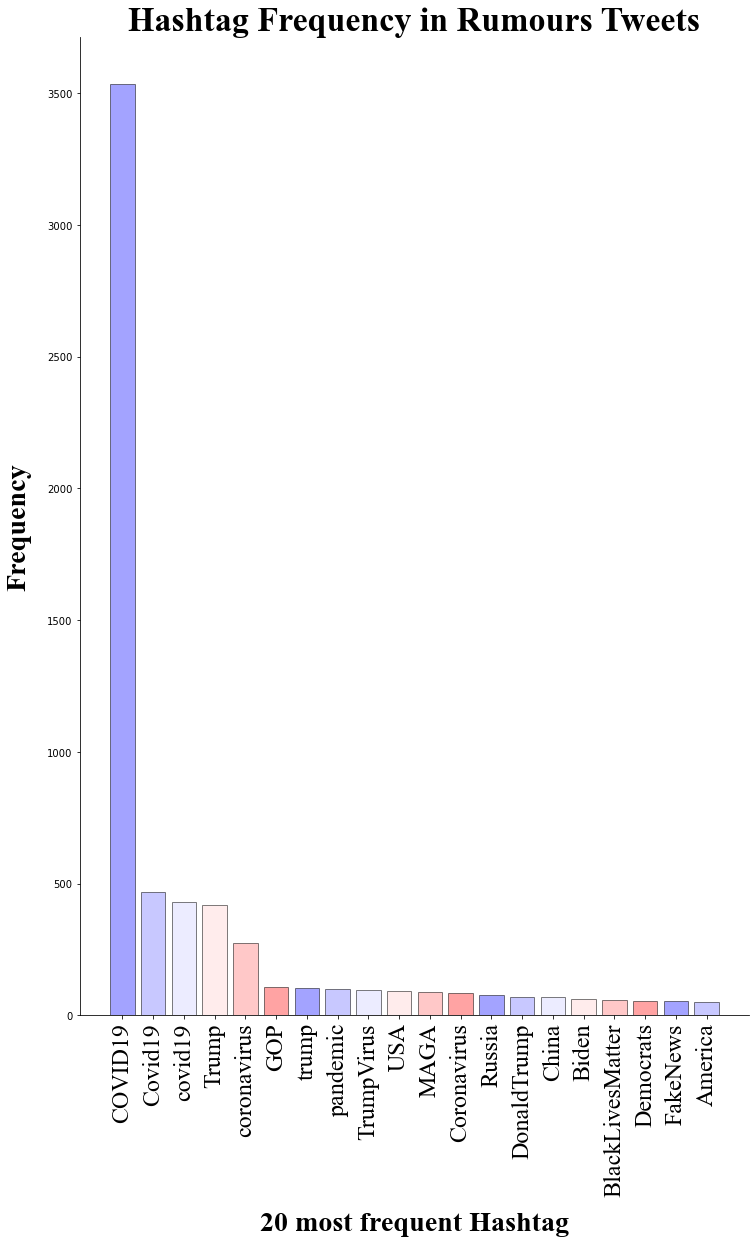

Index(['COVID19', 'Covid19', 'covid19', 'Trump', 'coronavirus', 'GOP', 'trump',
       'pandemic', 'TrumpVirus', 'USA', 'MAGA', 'Coronavirus', 'Russia',
       'DonaldTrump', 'China', 'Biden', 'BlackLivesMatter', 'Democrats',
       'FakeNews', 'America'],
      dtype='object')

In [261]:
visualize_freq(rumours, 'hashtags', 'Hashtag', 20, 'Rumours', 'hashtag-freq-rumours.png')

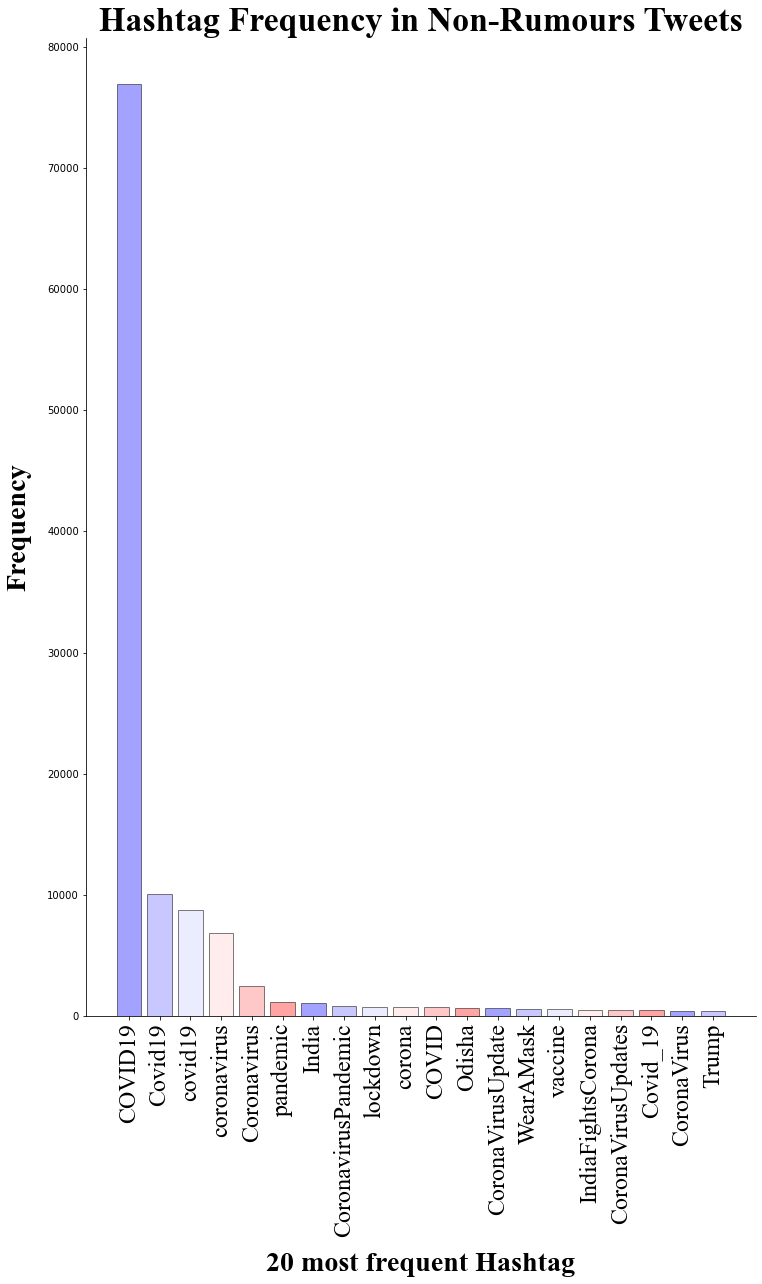

Index(['COVID19', 'Covid19', 'covid19', 'coronavirus', 'Coronavirus',
       'pandemic', 'India', 'CoronavirusPandemic', 'lockdown', 'corona',
       'COVID', 'Odisha', 'CoronaVirusUpdate', 'WearAMask', 'vaccine',
       'IndiaFightsCorona', 'CoronaVirusUpdates', 'Covid_19', 'CoronaVirus',
       'Trump'],
      dtype='object')

In [262]:
visualize_freq(nonrumours, 'hashtags', 'Hashtag', 20, 'Non-Rumours', 'hashtag-freq-nonrumours.png')

/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


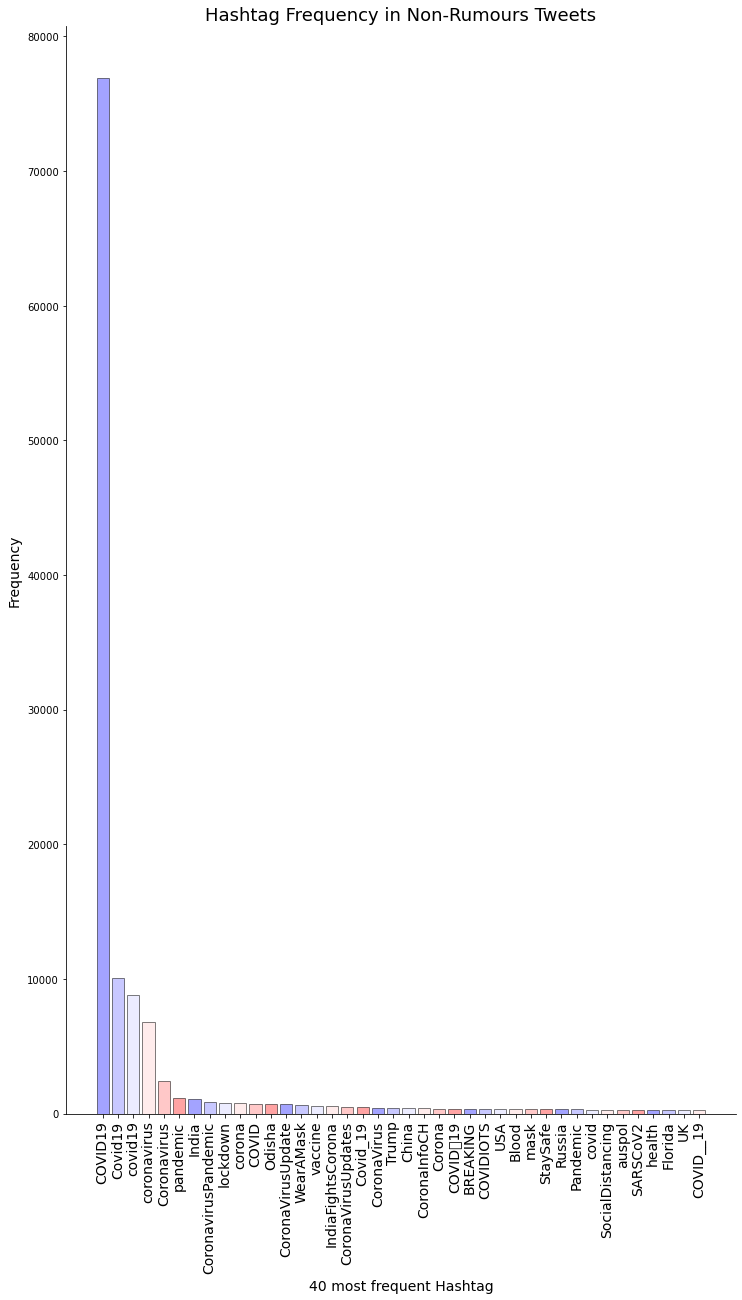

Index(['COVID19', 'Covid19', 'covid19', 'coronavirus', 'Coronavirus',
       'pandemic', 'India', 'CoronavirusPandemic', 'lockdown', 'corona',
       'COVID', 'Odisha', 'CoronaVirusUpdate', 'WearAMask', 'vaccine',
       'IndiaFightsCorona', 'CoronaVirusUpdates', 'Covid_19', 'CoronaVirus',
       'Trump', 'China', 'CoronaInfoCH', 'Corona', 'COVIDー19', 'BREAKING',
       'COVIDIOTS', 'USA', 'Blood', 'mask', 'StaySafe', 'Russia', 'Pandemic',
       'covid', 'SocialDistancing', 'auspol', 'SARSCoV2', 'health', 'Florida',
       'UK', 'COVID__19'],
      dtype='object')

In [48]:
visualize_freq(nonrumours, 'hashtags', 'Hashtag', 40, 'Non-Rumours', 'hashtag-freq-nonrumours.png')

In [49]:
rumour_hashtags = list(Counter(rumours['hashtags']).keys())
nonrumour_hashtags = list(Counter(nonrumours['hashtags']).keys())

common_hashtags = []
for hashtag in rumour_hashtags:
    if hashtag in nonrumour_hashtags:
        common_hashtags.append(hashtag)
common_rumour_percentage = round(len(common_hashtags) / len(rumour_hashtags), 4)
common_nonrumour_percentage = round(len(common_hashtags) / len(nonrumour_hashtags), 4)

print(common_rumour_percentage)
print(common_nonrumour_percentage)
print(len(common_hashtags))

0.1446
0.0179
850


#### Word Cloud Visualization

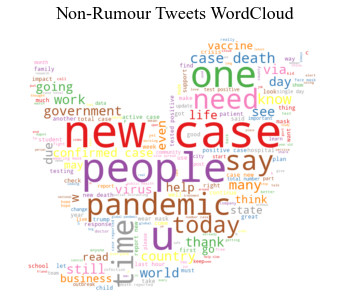

In [252]:
visualize_wordcloud(nonrumours_str, 'Non-Rumour', 'nonrumour-wc.png')

#### Rumours Topic Trends Overtime

In [18]:
covid_data['date'] = pd.to_datetime(covid_data['date'])
dates = []
for i in range(len(rumours)):
    date = rumours['date'][i]
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    date = date.strftime('%Y-%m-%d')
    if date not in dates:
        dates.append(date)

dates = sorted(dates)
periods = []
for i in range(4):
    period = dates[7*i:7*(i+1)]
    if i == 3:
        period = dates[21:]
    periods.append(period)

periods # 4 periods

[['2020-07-24',
  '2020-07-25',
  '2020-07-26',
  '2020-07-27',
  '2020-07-28',
  '2020-07-29',
  '2020-07-30'],
 ['2020-07-31',
  '2020-08-01',
  '2020-08-02',
  '2020-08-04',
  '2020-08-06',
  '2020-08-07',
  '2020-08-08'],
 ['2020-08-09',
  '2020-08-10',
  '2020-08-11',
  '2020-08-12',
  '2020-08-13',
  '2020-08-14',
  '2020-08-16'],
 ['2020-08-17', '2020-08-18', '2020-08-22', '2020-08-29', '2020-08-30']]

In [19]:
for i in range(len(periods)):
    start_time = periods[i][0]
    end_time = periods[i][-1]
    mask = (covid_data['date'] > start_time) & (covid_data['date'] <= end_time)
    if i == 0:
        period_1 = covid_data.loc[mask]
    if i == 1:
        period_2 = covid_data.loc[mask]
    if i == 2:
        period_3 = covid_data.loc[mask]
    if i == 3:
        period_4 = covid_data.loc[mask]

period_1 = period_1.reset_index(drop=True)
period_2 = period_2.reset_index(drop=True)
period_3 = period_3.reset_index(drop=True)
period_4 = period_4.reset_index(drop=True)

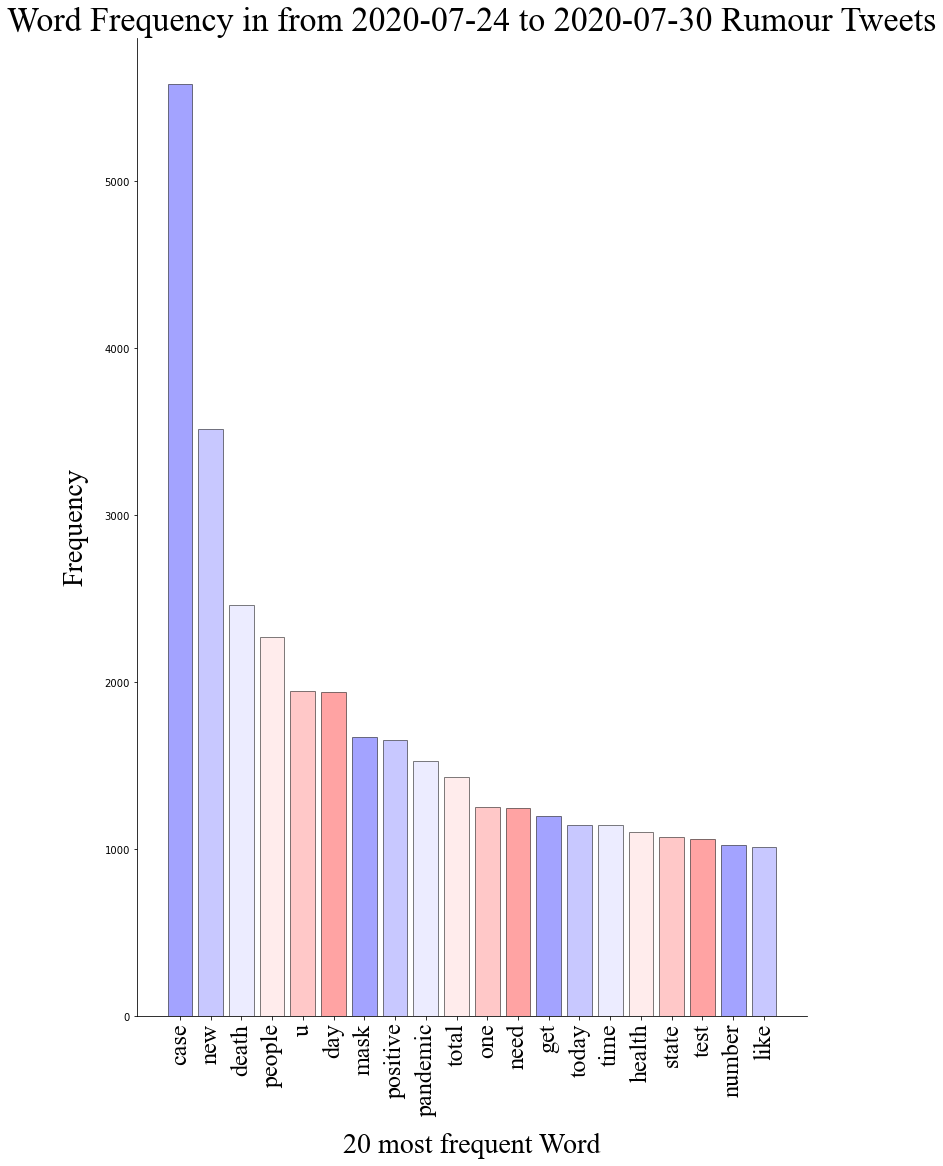

In [62]:
period_1_top_20_words = visualize_freq(period_1, 'text', 'Word', 20, 'from 2020-07-24 to 2020-07-30 Rumour', 'word-freq-rumour-period1.png')

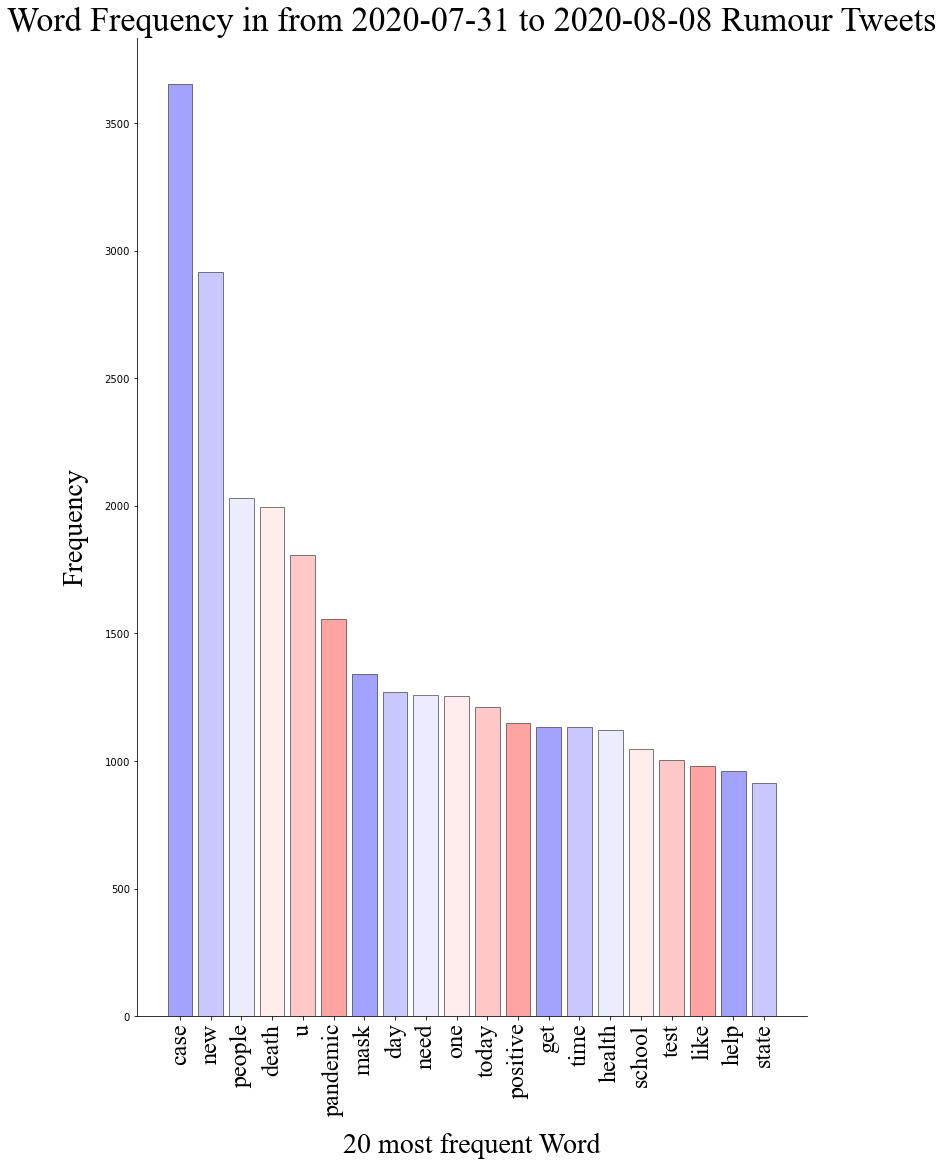

In [63]:
period_2_top_20_words = visualize_freq(period_2, 'text', 'Word', 20, 'from 2020-07-31 to 2020-08-08 Rumour', 'word-freq-rumour-period2.png')

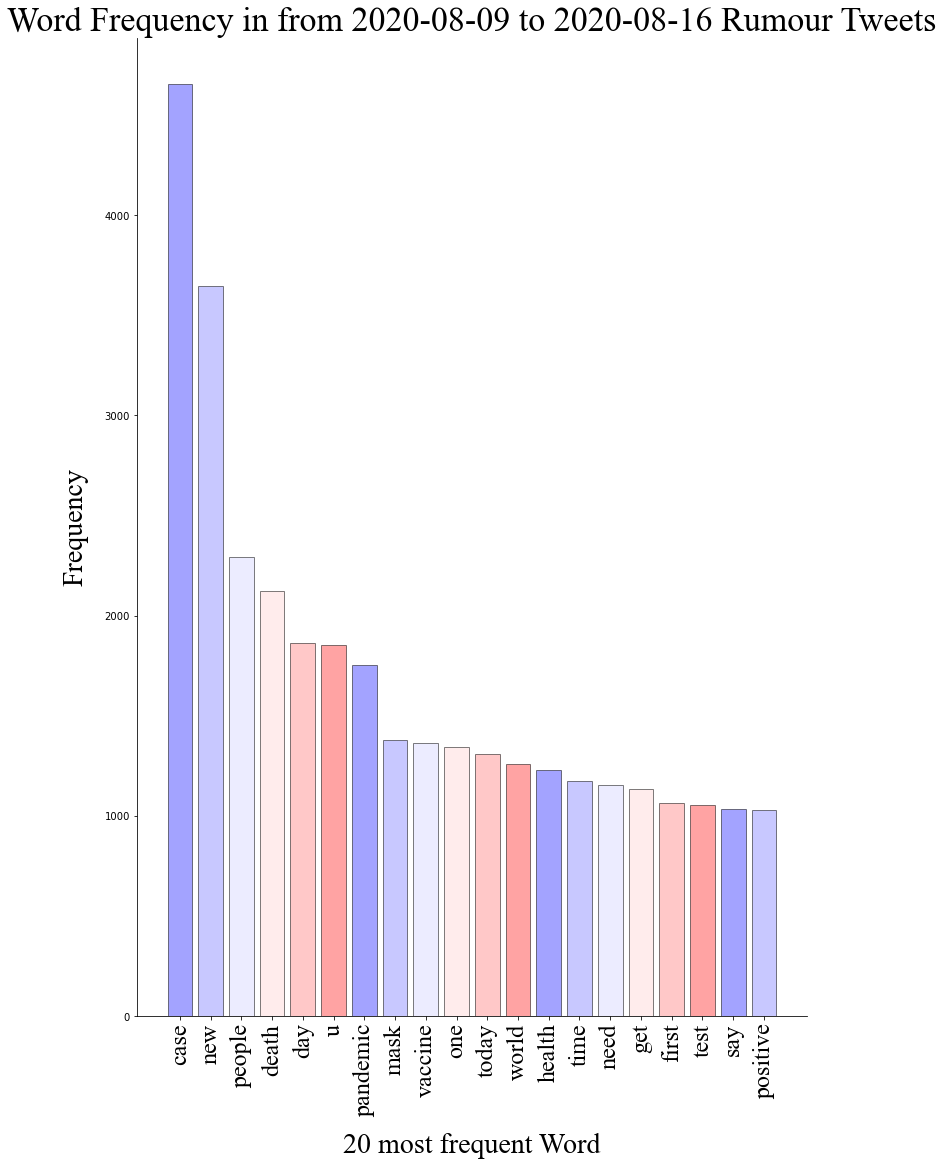

In [64]:
period_3_top_20_words = visualize_freq(period_3, 'text', 'Word', 20, 'from 2020-08-09 to 2020-08-16 Rumour', 'word-freq-rumour-period3.png')

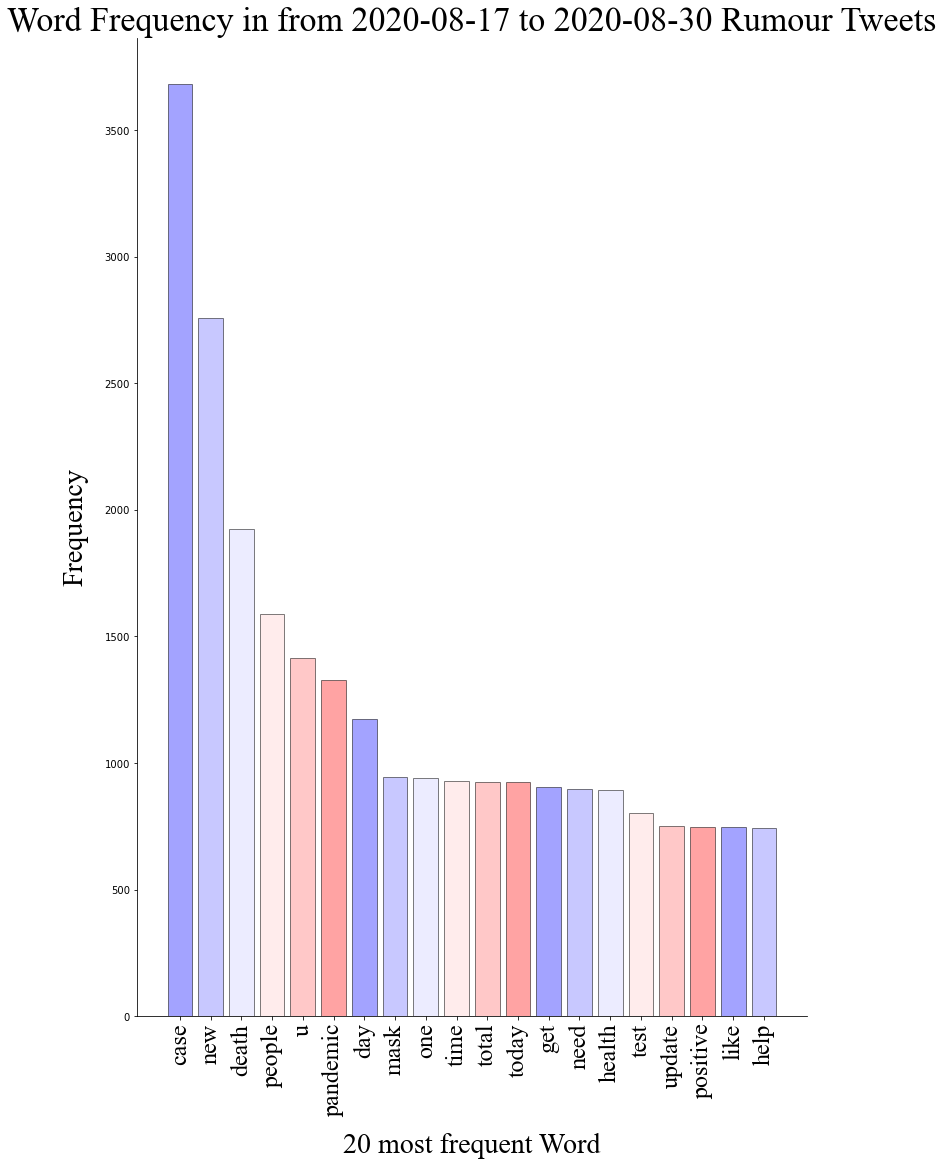

In [65]:
period_4_top_20_words = visualize_freq(period_4, 'text', 'Word', 20, 'from 2020-08-17 to 2020-08-30 Rumour', 'word-freq-rumour-period4.png')

In [66]:
frequent_words = list(period_1_top_20_words)
words = list(period_1_top_20_words) + list(period_2_top_20_words) + list(period_3_top_20_words) + list(period_4_top_20_words)
for word in words:
    if word not in frequent_words:
        frequent_words.append(word)

def period_word_cnt(set, word):
    corpus = []
    for i in range(len(set)):
        tweet = set['text'][i].split()
        if tweet != []:
            for val in tweet:
                corpus.append(val)
    counter = Counter(corpus)
    res = counter[word]
    return res

period1_freqs = {}
for word in frequent_words:
    freq = period_word_cnt(period_1, word)
    period1_freqs[word] = freq
frequent_words = sorted(period1_freqs, key=period1_freqs.get, reverse=True)

In [67]:
periods_freqs = []
for word in frequent_words:
    instance = []
    for i in range(4):
        if i == 0:
            freq = period_word_cnt(period_1, word)
        if i == 1:
            freq = period_word_cnt(period_2, word)
        if i == 2:
            freq = period_word_cnt(period_3, word)
        if i == 3:
            freq = period_word_cnt(period_4, word)
        instance.append(freq)
    periods_freqs.append(instance)

periods_freqs = pd.DataFrame(periods_freqs)
periods_freqs.index = frequent_words
colums = ['Period1','Period2', 'Period3', 'Peroid4']
periods_freqs.columns = colums
periods_freqs

,Period1,Period2,Period3,Peroid4
case,5579,3652,4654,3681
new,3514,2916,3645,2756
death,2463,1994,2122,1926
people,2273,2032,2295,1590
u,1946,1807,1856,1416
day,1941,1272,1862,1172
mask,1672,1342,1379,945
positive,1651,1147,1029,749
pandemic,1530,1556,1753,1327
total,1432,848,994,925


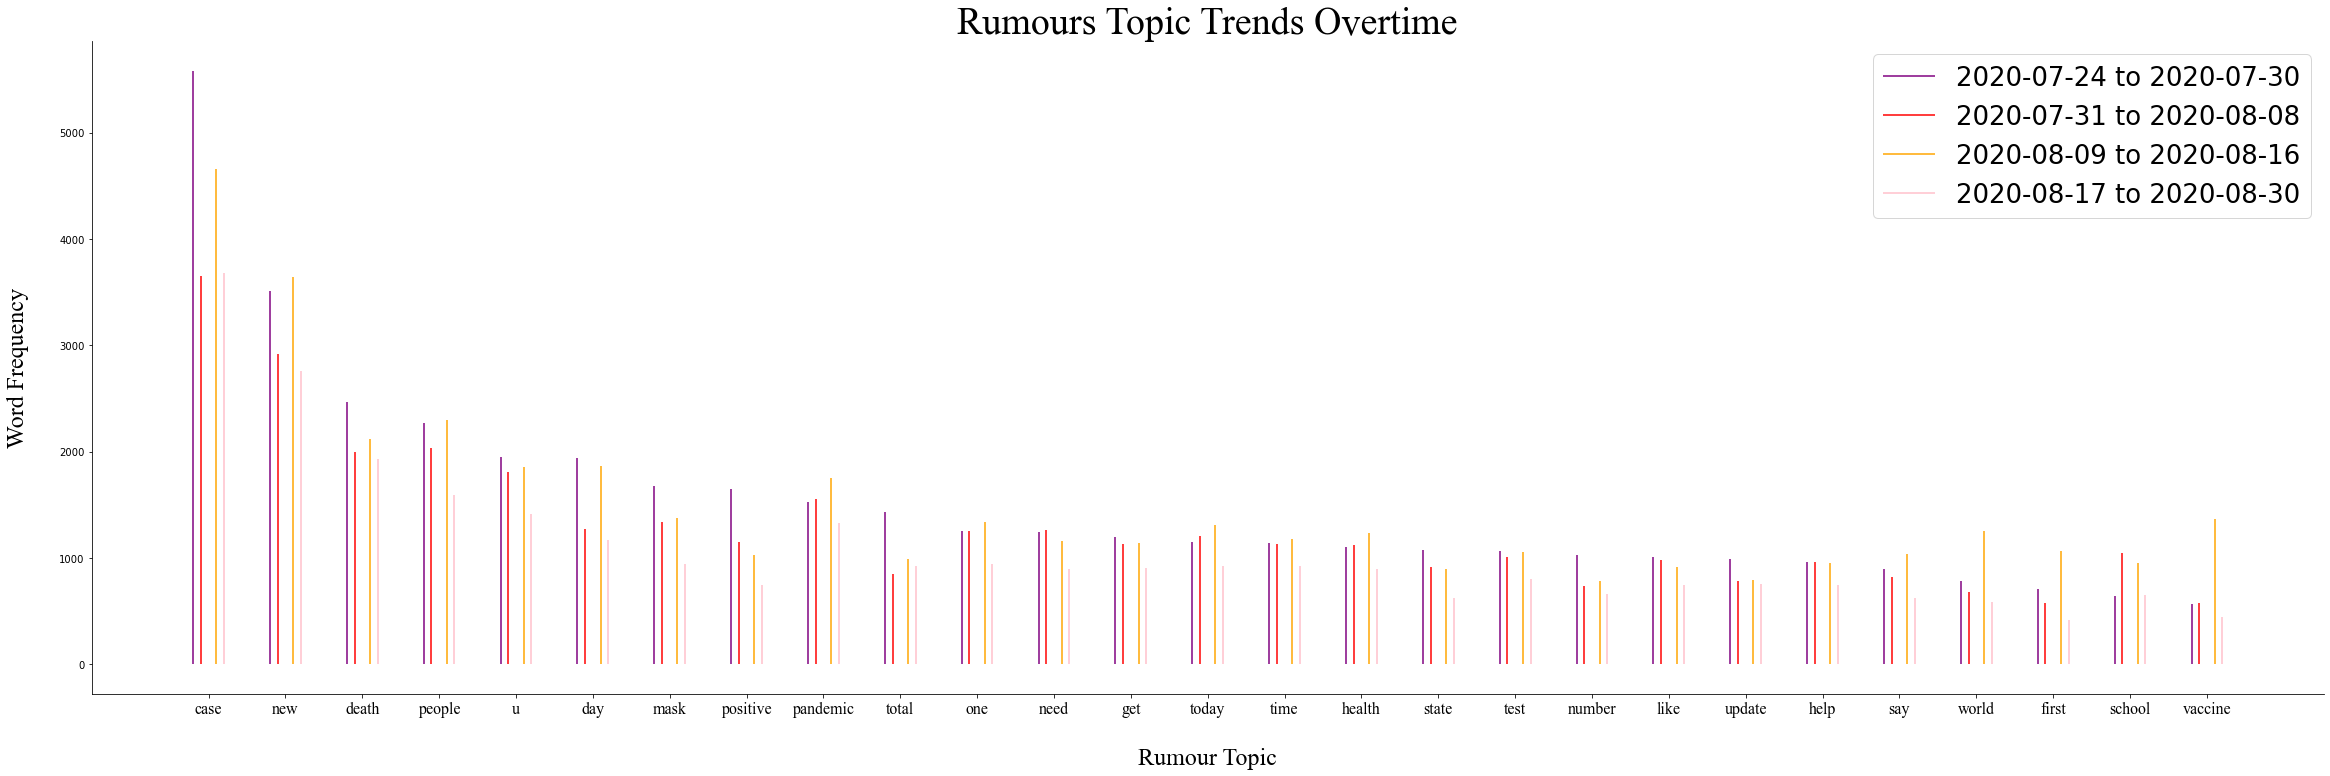

In [74]:
X = frequent_words 
y_period1 = list(periods_freqs['Period1'])
y_period2 = list(periods_freqs['Period2'])
y_period3 = list(periods_freqs['Period3'])
y_period4 = list(periods_freqs['Peroid4'])

X_axis = np.arange(len(X))
plt.figure(figsize=(40, 12))
plt.vlines(X_axis - 0.2, y_period1, 0.1, label = '2020-07-24 to 2020-07-30', color = 'purple')
plt.vlines(X_axis - 0.1, y_period2, 0.1, label = '2020-07-31 to 2020-08-08', color = 'red')
plt.vlines(X_axis + 0.1, y_period3 , 0.1, label = '2020-08-09 to 2020-08-16', color = 'orange')
plt.vlines(X_axis + 0.2, y_period4, 0.1, label = '2020-08-17 to 2020-08-30', color = 'pink')
plt.xticks(X_axis, X, size=16, fontname="Times New Roman")
plt.xlabel("Rumour Topic", size=24, labelpad=30, fontname="Times New Roman")
plt.ylabel("Word Frequency", size=24, labelpad=30, fontname="Times New Roman")
plt.title("Rumours Topic Trends Overtime", size=38, fontname="Times New Roman")
plt.legend(fontsize=26)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('images/trend.png', dpi=300, facecolor='w')
plt.show()

In [73]:
periods_freqs_percentage = []
for word in frequent_words:
    instance = []
    for i in range(4):
        if i == 0:
            freq = round(period_word_cnt(period_1, word) / sum(periods_freqs['Period1']), 4)*100
        if i == 1:
            freq = round(period_word_cnt(period_2, word) / sum(periods_freqs['Period2']), 4)*100
        if i == 2:
            freq = round(period_word_cnt(period_3, word) / sum(periods_freqs['Period3']), 4)*100
        if i == 3:
            freq = round(period_word_cnt(period_4, word) / sum(periods_freqs['Period4']), 4)*100
        instance.append(freq)
    periods_freqs_percentage.append(instance)

periods_freqs_percentage = pd.DataFrame(periods_freqs_percentage)
periods_freqs_percentage.index = frequent_words
colums = ['Period1','Period2', 'Period3', 'Peroid4']
periods_freqs_percentage.columns = colums
periods_freqs_percentage

,Period1,Period2,Period3,Peroid4
case,13.68,8.95,11.41,9.02
new,8.61,7.15,8.94,6.76
death,6.04,4.89,5.20,4.72
people,5.57,4.98,5.63,3.90
u,4.77,4.43,4.55,3.47
day,4.76,3.12,4.56,2.87
mask,4.10,3.29,3.38,2.32
positive,4.05,2.81,2.52,1.84
pandemic,3.75,3.81,4.30,3.25
total,3.51,2.08,2.44,2.27


In [ ]:
X = frequent_words 
y_period1 = list(periods_freqs_percentage['Period1'])
y_period2 = list(periods_freqs_percentage['Period2'])
y_period3 = list(periods_freqs_percentage['Period3'])
y_period4 = list(periods_freqs_percentage['Peroid4'])

X_axis = np.arange(len(X))
plt.figure(figsize=(20, 12))
plt.vlines(X_axis - 0.2, y_period1, 0.1, label = '2020-07-24 to 2020-07-30', color = 'purple')
plt.vlines(X_axis - 0.1, y_period2, 0.1, label = '2020-07-31 to 2020-08-08', color = 'red')
plt.vlines(X_axis + 0.1, y_period3 , 0.1, label = '2020-08-09 to 2020-08-16', color = 'orange')
plt.vlines(X_axis + 0.2, y_period4, 0.1, label = '2020-08-17 to 2020-08-30', color = 'pink')
plt.xticks(X_axis, X, size=16, fontname="Times New Roman")
plt.xlabel("Rumour Topic", size=24, labelpad=10, fontname="Times New Roman")
plt.ylabel("Word Frequency %", size=24, labelpad=10, fontname="Times New Roman")
plt.title("Rumours Topic Trends Overtime", size=38, fontname="Times New Roman")
plt.legend(fontsize=26)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('images/trend-percentage.png', dpi=300, facecolor='w')
plt.show()

#### Characteristics of Rumour-Creating Users Analysis

##### User Analysis

/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 129489 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127997 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/bac

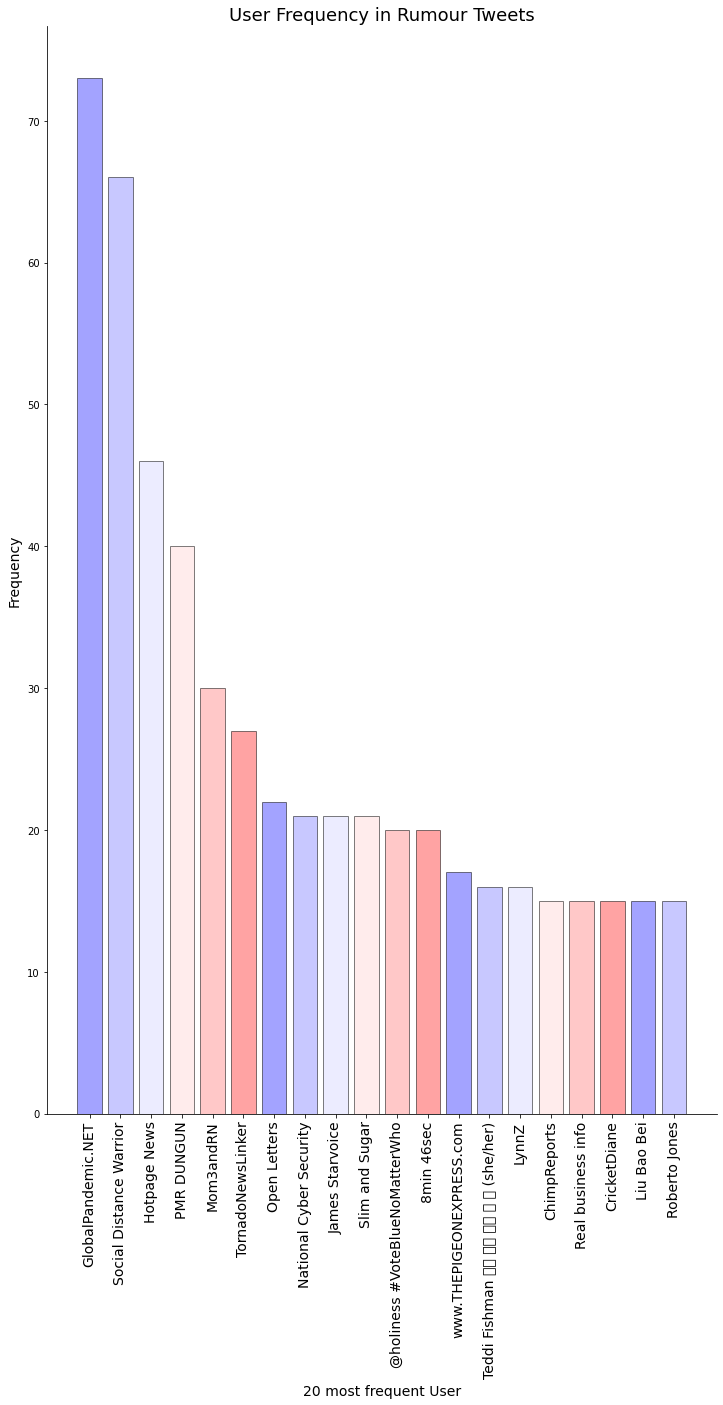

Index(['GlobalPandemic.NET', 'Social Distance Warrior', 'Hotpage News',
       'PMR DUNGUN', 'Mom3andRN', 'TornadoNewsLinker', 'Open Letters',
       'National Cyber Security', 'James Starvoice', 'Slim and Sugar',
       '@holiness #VoteBlueNoMatterWho', '8min 46sec',
       'www.THEPIGEONEXPRESS.com', 'Teddi Fishman 🧑🏽 👩🏾 👨🏻 📷 📺 (she/her)',
       'LynnZ', 'ChimpReports', 'Real business info', 'CricketDiane',
       'Liu Bao Bei', 'Roberto Jones'],
      dtype='object')

In [24]:
visualize_freq(rumours, 'user_name', 'User', 20, 'Rumour', 'usr-freq-rumour.png')

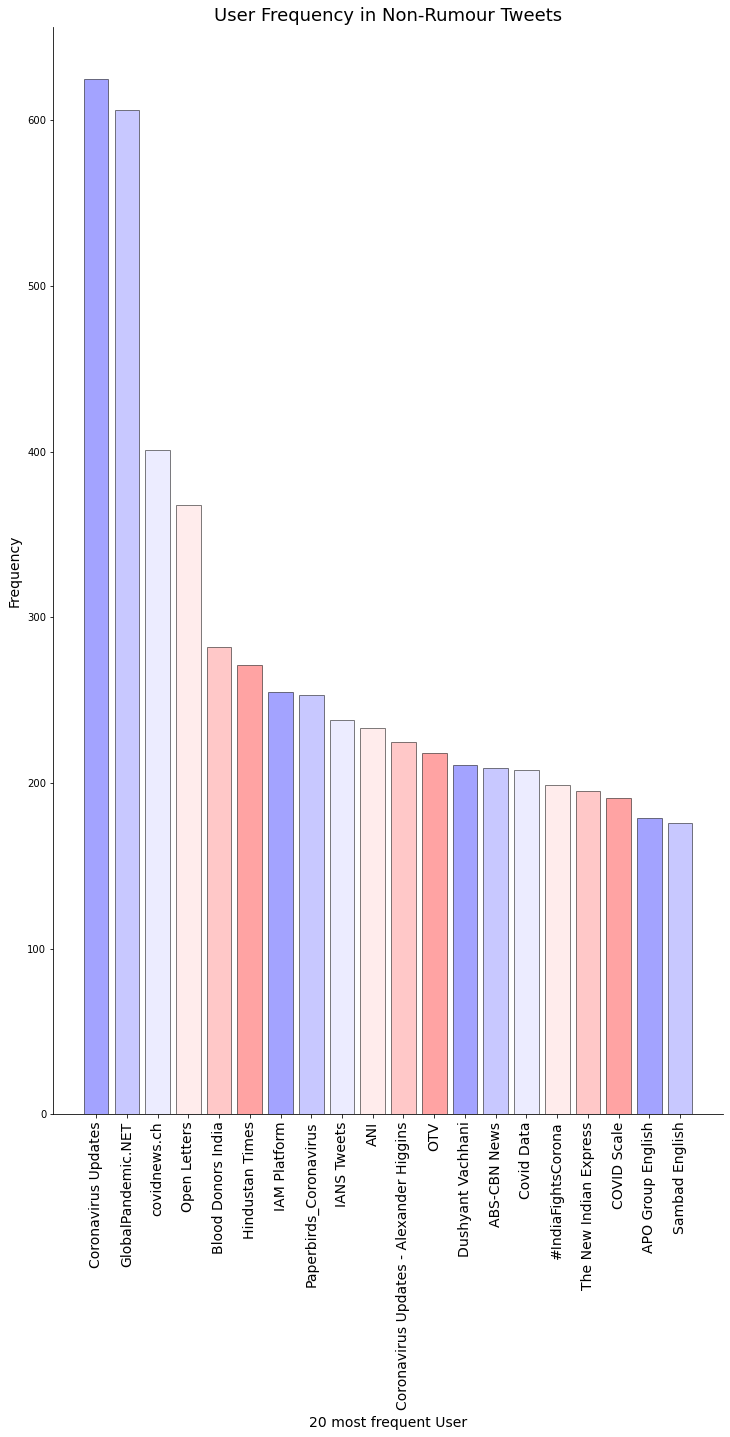

Index(['Coronavirus Updates', 'GlobalPandemic.NET', 'covidnews.ch',
       'Open Letters', 'Blood Donors India', 'Hindustan Times', 'IAM Platform',
       'Paperbirds_Coronavirus', 'IANS Tweets', 'ANI',
       'Coronavirus Updates - Alexander Higgins', 'OTV', 'Dushyant Vachhani',
       'ABS-CBN News', 'Covid Data', '#IndiaFightsCorona',
       'The New Indian Express', 'COVID Scale', 'APO Group English',
       'Sambad English'],
      dtype='object')

In [25]:
visualize_freq(nonrumours, 'user_name', 'User', 20, 'Non-Rumour', 'usr-freq-nonrumour.png')

,frequency
GlobalPandemic.NET,73
Social Distance Warrior,66
Hotpage News,46
PMR DUNGUN,40
Mom3andRN,30
TornadoNewsLinker,27
Open Letters,22
National Cyber Security,21
James Starvoice,21
Slim and Sugar,21


/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 129489 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127997 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sw/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/bac

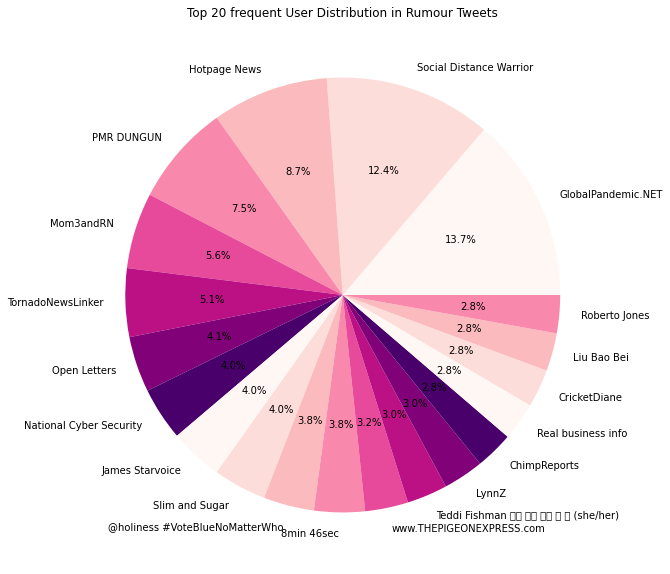

In [26]:
rumours_creators = visualize_distribution(rumours, 'user_name', 'User', 20, 'Rumour', 'usr-rumour-bar.png')
rumours_creators

,frequency
Coronavirus Updates,625
GlobalPandemic.NET,606
covidnews.ch,401
Open Letters,368
Blood Donors India,282
Hindustan Times,271
IAM Platform,255
Paperbirds_Coronavirus,253
IANS Tweets,238
ANI,233


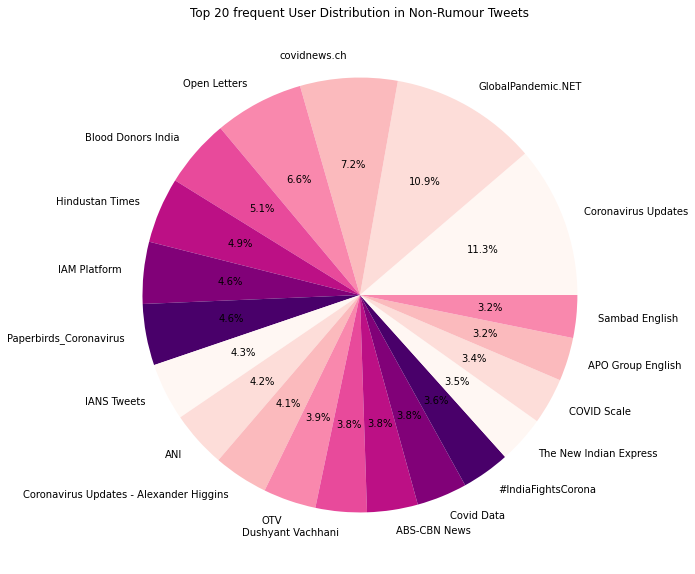

In [203]:
nonrumours_creators = visualize_distribution(nonrumours, 'user_name', 'User', 20, 'Non-Rumour', 'usr-nonrumour-bar.png')
nonrumours_creators

In [220]:
r_creators = list(rumours_creators.index)
r_creators_records = rumours[rumours['user_name'].isin(r_creators)]
r_creators_records = r_creators_records.drop_duplicates(subset='user_name', keep='first')
r_creators_records.index = r_creators_records.user_name
r_creators_records = r_creators_records.reindex(r_creators)
r_creators_records = pd.concat([rumours_creators, r_creators_records], axis=1)
r_creators_records

,frequency,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,label
GlobalPandemic.NET,73,GlobalPandemic.NET,WORLDWIDE,breaking news critical information survive out...,2010-07-13 21:58:05,26108,26003,2,False,2020-07-25 10:55:22,alert f b pledged keep source anonymous trump ...,NaN,GlobalPandemic.NET,False,1
Social Distance Warrior,66,Social Distance Warrior,NaN,believe science,2020-04-15 14:12:10,2,4,0,False,2020-07-25 11:15:42,trump pandemic,"['MAGA2020', 'COVID19']","Cheap Bots, Done Quick!",False,1
Hotpage News,46,Hotpage News,United States,top headline day,2009-03-12 14:16:30,26296,13318,1,False,2020-07-25 02:36:49,tucker state obvious drudge turned trump,"['Biden', 'Trump', 'GOP', 'Republican', 'Democ...",Twitter Web App,False,1
PMR DUNGUN,40,PMR DUNGUN,"Dungun, Terengganu",,2018-07-17 03:32:33,199,517,17545,False,2020-08-09 09:04:52,sharing caring,"['MalaysiaPrihatin', 'MerdekaMoment', 'Malaysi...",Twitter for Android,False,1
Mom3andRN,30,Mom3andRN,NaN,mph specialty yr infectious disease therapy ig...,2014-06-14 02:08:51,53,152,6607,False,2020-07-28 05:48:13,includes vet cop amp nurse want u amp,NaN,Twitter for iPhone,False,1
TornadoNewsLinker,27,TornadoNewsLinker,"Londonderry, Northern Ireland",,2016-04-23 15:30:03,4711,4442,137297,False,2020-07-31 17:12:43,along people like certain premiership football...,"['Globalists', 'SillyBilly', 'LadyGaga', 'Mado...",Twitter Web App,False,1
Open Letters,22,Open Letters,Text RESIST to 50409,copy real letter delivered president congress ...,2017-12-06 22:18:07,17161,3,2,True,2020-07-25 02:59:55,sign bounty deliver copy official,NaN,Resistbot Open Letters,False,1
National Cyber Security,21,National Cyber Security,"Atlanta, GA",leader download national security,2010-01-27 22:48:24,5426,161,8,False,2020-07-25 09:48:44,fall scammer posing health worker pandemic,"['coronavirus', 'scams', 'covid19']",WordPress.com,False,1
James Starvoice,21,James Starvoice,"San Diego, CA",defying impossible,2017-06-26 00:51:40,114,348,1340,False,2020-07-25 07:37:40,made novel free enjoy,"['fantasy', 'thriller', 'fiction', 'suspense']",Twitter Web App,False,1
Slim and Sugar,21,Slim and Sugar,"South West, England",hi thanks dropping sell vintage antique seeker...,2015-12-06 23:16:15,3050,4990,44559,False,2020-08-08 13:10:03,getting yet lied laughing u easy cont,['WakeUp'],Twitter Web App,False,1


In [221]:
non_r_creators = list(nonrumours_creators.index)
non_r_creators_records = nonrumours[nonrumours['user_name'].isin(non_r_creators)]
non_r_creators_records = non_r_creators_records.drop_duplicates(subset='user_name', keep='first')
non_r_creators_records.index = non_r_creators_records.user_name
non_r_creators_records = non_r_creators_records.reindex(non_r_creators)
non_r_creators_records = pd.concat([nonrumours_creators, non_r_creators_records], axis=1)
non_r_creators_records

,frequency,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,label
Coronavirus Updates,625,Coronavirus Updates,NaN,latest news statistic post update come stats o...,2020-03-07 12:52:51,433,1,0,False,2020-07-25 12:22:11,new case new death,"['coronavirus', 'CoronaVirusUpdate', 'COVID19'...",COVID19-Updates,False,0
GlobalPandemic.NET,606,GlobalPandemic.NET,WORLDWIDE,breaking news critical information survive out...,2010-07-13 21:58:05,26108,26003,2,False,2020-07-25 12:20:23,alert eye opener rep john remembered global pa...,"['Coronavirus', 'COVID19', 'Protests']",GlobalPandemic.NET,False,0
covidnews.ch,401,covidnews.ch,Switzerland,statistic information news,2020-03-21 16:13:52,352,1881,148,False,2020-07-25 11:31:26,student researcher brainstorm,"['CoronaInfoCH', 'COVID19', 'corona', 'canada']",FS Poster,False,0
Open Letters,368,Open Letters,Text RESIST to 50409,copy real letter delivered president congress ...,2017-12-06 22:18:07,17161,3,2,True,2020-07-25 12:07:43,sign protect people deliver copy official,NaN,Resistbot Open Letters,False,0
Blood Donors India,282,Blood Donors India,"Mumbai, India",focused matching blood donor need follower con...,2008-12-23 07:55:39,1215920,2047,19359,True,2020-07-25 12:26:26,need type b positive hospital blood component ...,"['Kolar', 'Blood', 'COVID19']",Blood Donors India,False,0
Hindustan Times,271,Hindustan Times,India,one largest medium company latest news around ...,2009-04-29 10:11:34,7647627,126,2960,True,2020-07-25 11:19:29,serum institute seek nod phase clinical trial ...,['COVID19'],TweetDeck,False,0
IAM Platform,255,IAM Platform,Worldwide,tool tip service platform power network go blo...,2010-12-13 21:24:29,17815,14941,65440,False,2020-07-25 12:23:32,well tightens purse string ride pandemic read,['cdc'],IAMBLOG2TWITTER,False,0
Paperbirds_Coronavirus,253,Paperbirds_Coronavirus,NaN,initiative committed deliver unbiased daily li...,2019-11-05 15:55:40,141,3,17,False,2020-07-25 11:37:32,news call school reopen downplaying health risk,"['coronavirus', 'COVID19', '2019ncov']",dlvr.it,False,0
IANS Tweets,238,IANS Tweets,New Delhi,largest independent news agency,2010-05-08 13:21:45,52155,45,65,True,2020-07-25 11:23:25,per information offered financial support four...,['SFJ'],Twitter Web App,False,0
ANI,233,ANI,India,news international multi medium news agency co...,2011-08-16 05:23:41,4515177,0,0,True,2020-07-25 12:09:27,positive case patient recovered discharged mig...,['COVID19'],Twitter Web App,False,0


##### User Followers Analysis

In [197]:
for i in range(len(rumours)):
    usr = rumours['user_name'][i]
    followers = rumours['user_followers'][i]
    if followers == max(list(rumours['user_followers'])):
        print(usr)
        print(followers)
        break

cgtn_cnt = 0
for i in range(len(rumours)):
    usr = rumours['user_name'][i]
    tweet = rumours['text'][i]
    if usr == 'CGTN':
        cgtn_cnt += 1
        print(tweet)
        
cgtn_cnt

# CGTN造谣四次，粉丝数做多  13892839 # 一千三百万

CGTN
13892839
civil aviation recovers daily flight increase daily number civil aviation flight reached
balloon released honor death
official military exercise pushed back due
smiley face captured blue sky northeastern japan city august air race


4

In [201]:
max_follower_unrumour = max(list(nonrumours['user_followers']))
for i in range(len(nonrumours)):
    usr = nonrumours['user_name'][i]
    tweet = nonrumours['text'][i]
    followers = nonrumours['user_followers'][i]
    if followers == max_follower_unrumour:
        print(usr)
        print(tweet)
        print(followers)
        break

CNN
thought show hair please take seriously revealed
49442559


##### Location Analysis

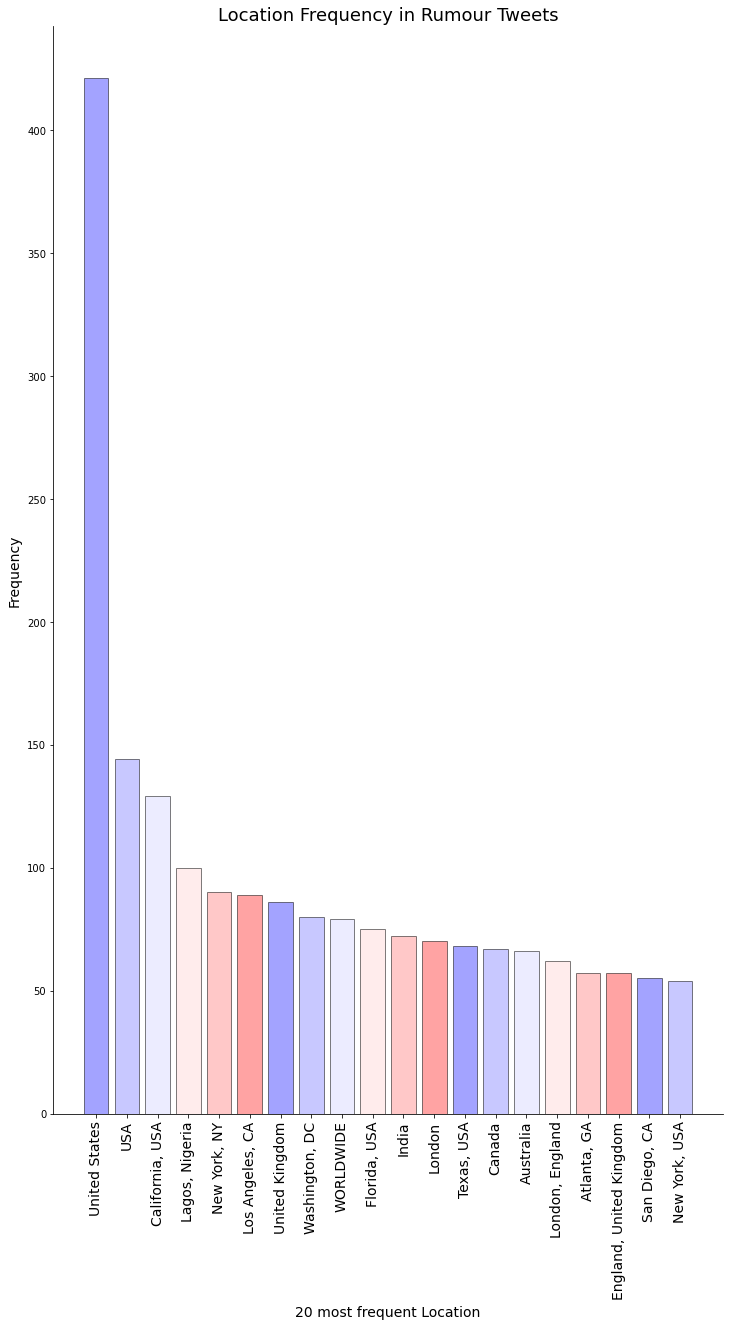

Index(['United States', 'USA', 'California, USA', 'Lagos, Nigeria',
       'New York, NY', 'Los Angeles, CA', 'United Kingdom', 'Washington, DC',
       'WORLDWIDE', 'Florida, USA', 'India', 'London', 'Texas, USA', 'Canada',
       'Australia', 'London, England', 'Atlanta, GA',
       'England, United Kingdom', 'San Diego, CA', 'New York, USA'],
      dtype='object')

In [168]:
visualize_freq(rumours, 'user_location', 'Location', 20, 'Rumour', 'location-freq-rumour.png')

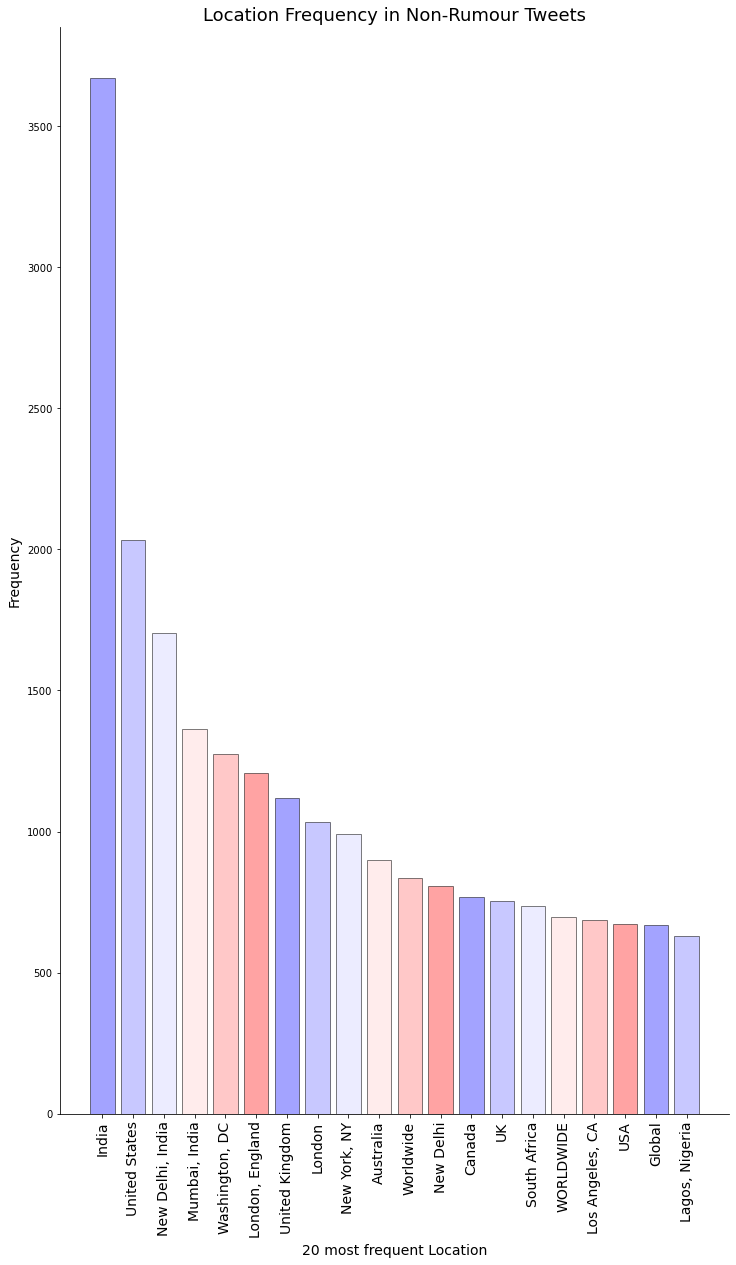

Index(['India', 'United States', 'New Delhi, India', 'Mumbai, India',
       'Washington, DC', 'London, England', 'United Kingdom', 'London',
       'New York, NY', 'Australia', 'Worldwide', 'New Delhi', 'Canada', 'UK',
       'South Africa', 'WORLDWIDE', 'Los Angeles, CA', 'USA', 'Global',
       'Lagos, Nigeria'],
      dtype='object')

In [169]:
visualize_freq(nonrumours, 'user_location', 'Location', 20, 'Non-Rumour', 'location-freq-nonrumour.png')

,frequency
India,3669
United States,2034
"New Delhi, India",1702
"Mumbai, India",1363
"Washington, DC",1274
"London, England",1207
United Kingdom,1120
London,1033
"New York, NY",992
Australia,898


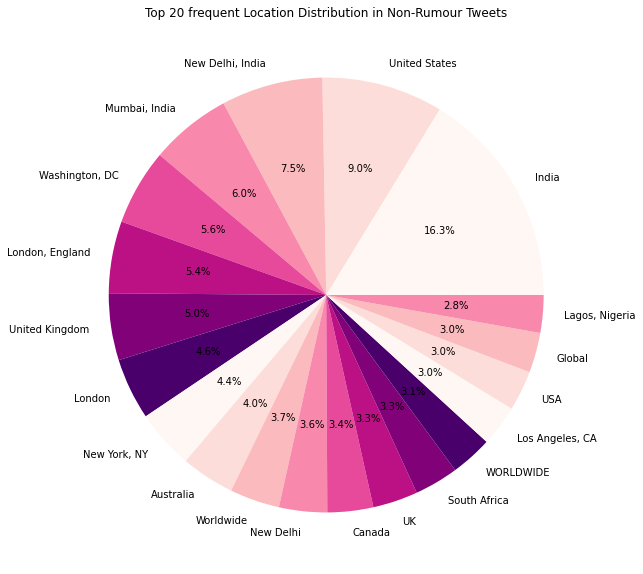

In [171]:
nonrumour_locations = visualize_distribution(nonrumours, 'user_location', 'Location', 20, 'Non-Rumour', 'location-nonrumour-bar.png')
nonrumour_locations

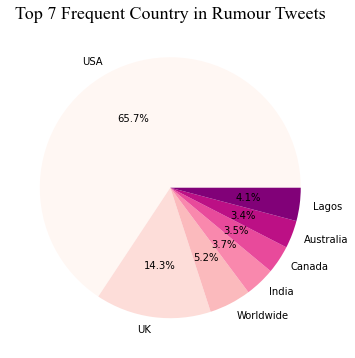

In [342]:
reconstruct_locations = ['USA', 'UK', 'Worldwide', 'India', 'Canada', 'Australia', 'Lagos', ]
reconstruct_locations_freq = [421+144+129+90+89+80+75+68+57+55+54, 86+70+62+57, 100, 72, 67, 66, 79]
reconstruct_locations_freq = pd.DataFrame(reconstruct_locations_freq)
reconstruct_locations_freq.columns = ['frequency']
reconstruct_locations_freq.index = reconstruct_locations

set_type = 'Rumour'
output_fname = 'rumour-country.png'
# plot
cmap = plt.get_cmap('RdPu')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.figure(figsize=(6, 6))
plt.pie(reconstruct_locations_freq['frequency'], labels = list(reconstruct_locations_freq.index), autopct='%1.1f%%', colors=colors)
title = "Top 7 Frequent Country in {} Tweets".format(set_type)
plt.title(title, size=18, fontname="Times New Roman")
plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
plt.show()

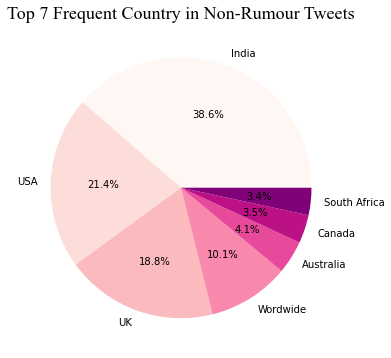

In [346]:
reconstruct_nonrumour_locations = ['India', 'USA', 'UK', 'Wordwide', 'Australia', 'Canada', 'South Africa']
reconstruct_nonrumour_locations_freq = [3669+1702+1363+892+806, 2034+1274+697+673, 1207+1120+1033+755, 836+698+670, 898, 768, 738]
reconstruct_nonrumour_locations_freq = pd.DataFrame(reconstruct_nonrumour_locations_freq)
reconstruct_nonrumour_locations_freq.columns = ['frequency']
reconstruct_nonrumour_locations_freq.index = reconstruct_nonrumour_locations

set_type = 'Non-Rumour'
output_fname = 'non-rumour-country.png'
# plot
cmap = plt.get_cmap('RdPu')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.figure(figsize=(6, 6))
plt.pie(reconstruct_nonrumour_locations_freq['frequency'], labels = list(reconstruct_nonrumour_locations_freq.index), autopct='%1.1f%%', colors=colors)
title = "Top 7 Frequent Country in {} Tweets".format(set_type)
plt.title(title, size=18, fontname="Times New Roman")
plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
plt.show()

##### User Description Analysis

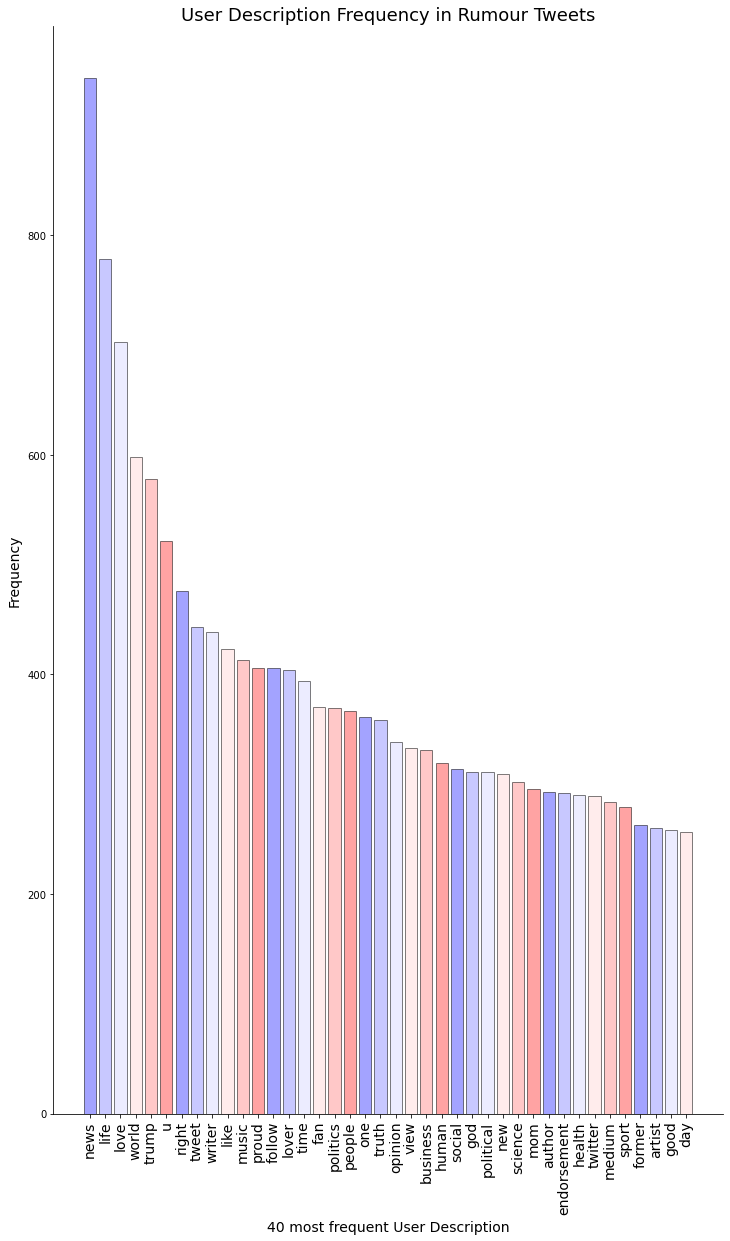

Index(['news', 'life', 'love', 'world', 'trump', 'u', 'right', 'tweet',
       'writer', 'like', 'music', 'proud', 'follow', 'lover', 'time', 'fan',
       'politics', 'people', 'one', 'truth', 'opinion', 'view', 'business',
       'human', 'social', 'god', 'political', 'new', 'science', 'mom',
       'author', 'endorsement', 'health', 'twitter', 'medium', 'sport',
       'former', 'artist', 'good', 'day'],
      dtype='object')

In [222]:
visualize_freq(rumours, 'user_description', 'User Description', 40, 'Rumour', 'usr-des-freq-rumour.png')

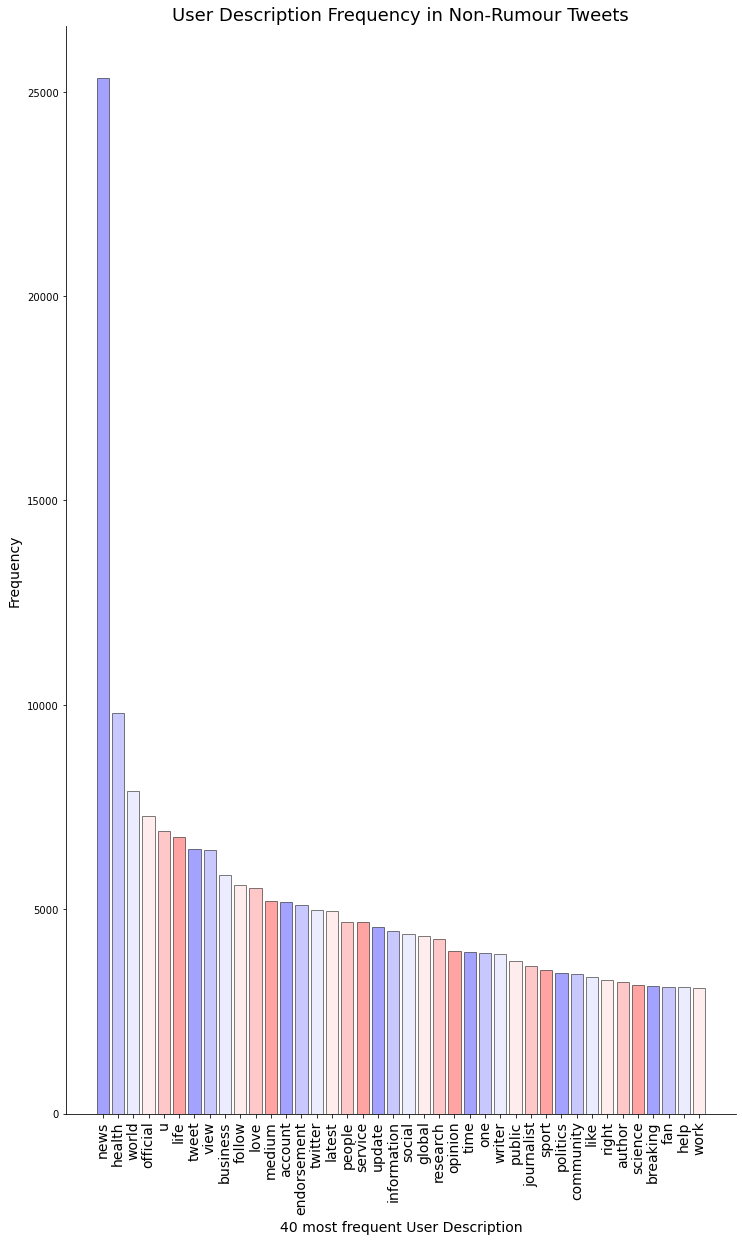

Index(['news', 'health', 'world', 'official', 'u', 'life', 'tweet', 'view',
       'business', 'follow', 'love', 'medium', 'account', 'endorsement',
       'twitter', 'latest', 'people', 'service', 'update', 'information',
       'social', 'global', 'research', 'opinion', 'time', 'one', 'writer',
       'public', 'journalist', 'sport', 'politics', 'community', 'like',
       'right', 'author', 'science', 'breaking', 'fan', 'help', 'work'],
      dtype='object')

In [223]:
visualize_freq(nonrumours, 'user_description', 'User Description', 40, 'Non-Rumour', 'usr-des-freq-nonrumour.png')

##### User Verify Analysis

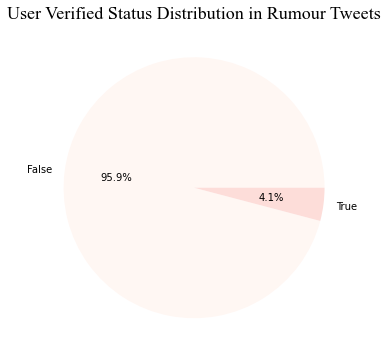

,frequency
False,14254
True,609


In [14]:
visualize_distribution(rumours, 'user_verified', 'User Verified Status', 2, 'Rumour', 'usr-verify-rumour.png')

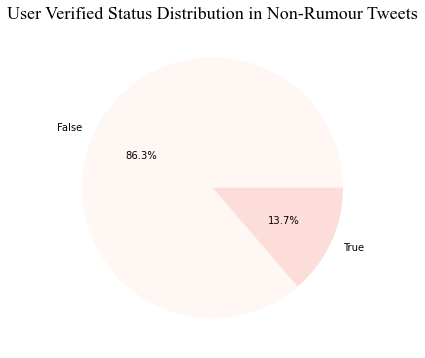

,frequency
False,141759
True,22486


In [16]:
visualize_distribution(nonrumours, 'user_verified', 'User Verified Status', 2, 'Non-Rumour', 'usr-verify-non-rumour.png')

##### User Account Created Date Analysis

,frequency
2009,2291
2020,2007
2011,1341
2019,1160
2010,1147
2012,1052
2017,1010
2013,940
2016,860
2018,837


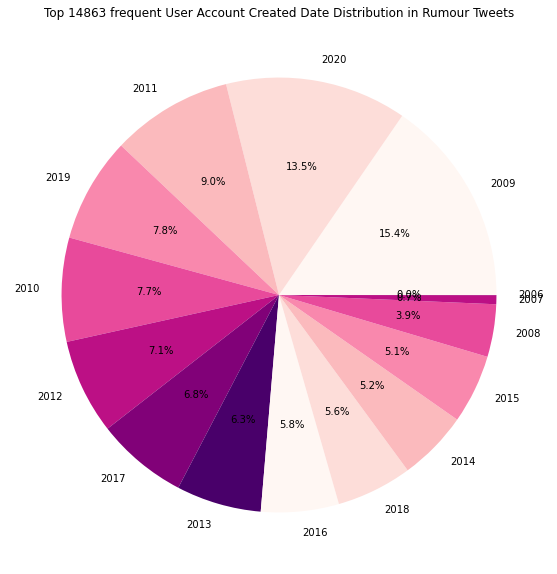

In [228]:
visualize_distribution(rumours, 'user_created', 'User Account Created Date', len(rumours), 'Rumour', 'usr-created-date-rumour-bar.png')

,frequency
2009,26740
2020,20421
2010,15775
2011,15420
2012,12481
2019,10954
2013,10626
2017,9601
2014,8953
2015,8878


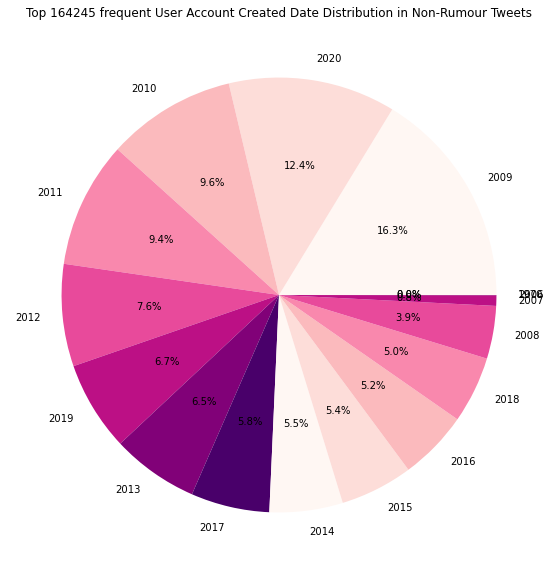

In [229]:
visualize_distribution(nonrumours, 'user_created', 'User Account Created Date', len(nonrumours), 'Non-Rumour', 'usr-created-date-nonrumour-bar.png')

#### Source Analysis

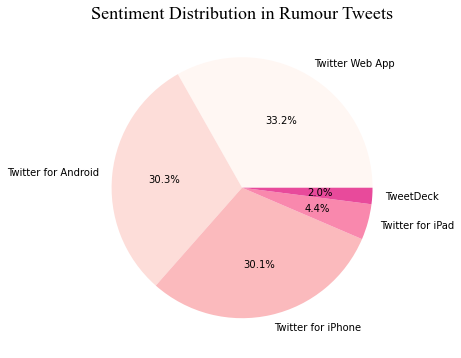

,frequency
Twitter Web App,4544
Twitter for Android,4148
Twitter for iPhone,4114
Twitter for iPad,605
TweetDeck,277


In [349]:
visualize_distribution(rumours, 'source', 'Source', 5, 'Rumour', 'rumour-source.png')

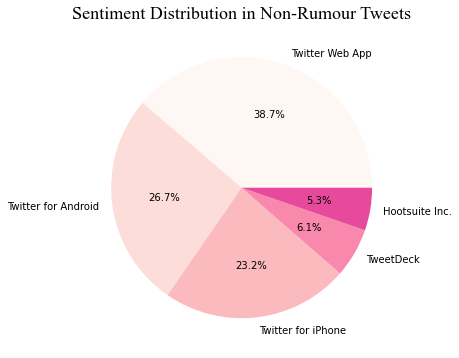

,frequency
Twitter Web App,52347
Twitter for Android,36031
Twitter for iPhone,31358
TweetDeck,8266
Hootsuite Inc.,7156


In [350]:
visualize_distribution(nonrumours, 'source', 'Source', 5, 'Non-Rumour', 'nonrumour-source.png')

In [254]:
len(Counter(covid_data['source'])) 

611